In [261]:
import matlab.engine
import pylab
import numpy as np
import scipy.integrate as scp
from pylab import *
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import csv
import os
import sys
import copy
from scipy.optimize import minimize
import pandas as pd
import math
from jax import jax, lax, jit
import optax
import jax.numpy as jnp
from functools import partial 
import time 
import sobol_seq
import site

print("All modules are installed and imported successfully.")

All modules are installed and imported successfully.


In [262]:
#current directory
dir = os.getcwd()
# go back one folder
dir = os.path.dirname(dir)
# open the folder called Data
dir = os.path.join(dir, 'Data')
file_path_1 = os.path.join(dir, '30State_Traj1_for5min_0405.csv')
file_path_2 = os.path.join(dir, '30State_Traj2_for5min_0405.csv')
file_path_3 = os.path.join(dir, '30State_Traj3_for5min_0405.csv')

df = pd.read_csv(file_path_1)
df.reset_index(drop=True, inplace=True)
data_raw1 = df.values

df = pd.read_csv(file_path_2)
df.reset_index(drop=True, inplace=True)
data_raw2 = df.values

df = pd.read_csv(file_path_3)
df.reset_index(drop=True, inplace=True)
data_raw3 = df.values


In [263]:
datasets = [data_raw1, data_raw2, data_raw3]
Xdat_list = []
Ydat_list = []
xt_real_list = []
controls_list = []
#xt_list = []
N_state = 30

for data_raw in datasets:
    # Extract indices for every state
    selected_indices = np.arange(0, len(data_raw[:, 0]), 300)[:N_state] #Selected_indices = timestamps for which the sampling was done in the raw data
    data_state = data_raw[selected_indices, :] #Selected all the columns of the sampled rows (every 300th row selectes all the data from all columns)


    Xdat_temp = data_state[:-1, :] #All rows up to the last row and all the columns from the sample dataset
    Ydat_temp = data_state[1:, :-2] - data_state[:-1, :-2] #(All rows except the first one and all columns except the last two). Subtracting each from the row that follows it. The delta.
    controls_temp = data_state[:-1, -2:] # same as Xdat_temp[:,-2:]

    # Append the results to their respective lists
    Xdat_list.append(Xdat_temp)
    Ydat_list.append(Ydat_temp)
    xt_real_list.append(data_state.T)  # Transposed for consistency
    controls_list.append(controls_temp.T)

# Concatenate the lists into single arrays
###### why cant we train it without concatenate??
Xdat = np.concatenate(Xdat_list, axis=0) #Xdat is 29 samples of every column (11) from each of the 3 datasets, because need Ydat and Xdat dimensions to be the same and Ydat is 30-1. Therefore 30-3.
                                         #Xdat shape is (87,11)

Ydat = np.concatenate(Ydat_list, axis=0) #Ydat is the delta between all the states for the 30 samples.
                                         #Ydat shape is (87,9)
xt_real = np.stack(xt_real_list)

#xt_real = np.concatenate(xt_real_list, axis=1)  # Note the axis=1 due to transposition
controls = np.transpose(np.array(controls_list), axes=(1, 0, 2))
# xt = np.concatenate(xt_list, axis=1)


hp_0   = controls[0]
Qair_0 = controls[1] #Samples 300th row 30 times but theres only 29 elements in these lists?




# Build GP model without evolutionary algorithm

In [264]:
class GP_model_1:

    ###########################
    # --- initializing GP --- #
    ###########################
    def __init__(self, X, Y, kernel, multi_hyper, var_out=True):

        # GP variable definitions
        self.X, self.Y, self.kernel = jnp.array(X), jnp.array(Y), kernel
        self.n_point, self.nx_dim   = X.shape[0], X.shape[1]
        self.ny_dim                 = Y.shape[1]
        self.multi_hyper            = multi_hyper
        self.var_out                = var_out

        # normalize data
        self.X_mean, self.X_std     = jnp.mean(X, axis=0), jnp.std(X, axis=0)
        self.Y_mean, self.Y_std     = jnp.mean(Y, axis=0), jnp.std(Y, axis=0)
        self.X_norm, self.Y_norm    = (X-self.X_mean)/self.X_std, (Y-self.Y_mean)/self.Y_std

        # determine hyperparameters
        self.hypopt, self.invKopt   = self.determine_hyperparameters()

    #############################
    # --- Covariance Matrix --- #
    #############################
    
    #@partial(jax.jit, static_argnums=(0, 1)) #Treating 'self' and 'kernel' arguments as static/constant (arguments that JAX doesen't include in its JIT-compilation
    def Cov_mat(self, kernel, X_norm, W, sf2): #X_norm, W and sf2 already JAX arrays
        #start_time = time.time()
        '''
        Calculates the covariance matrix of a dataset Xnorm
        '''
        if kernel == 'RBF':
            #Using Scipy standardised euclidean distance:

            diff = X_norm[:, None, :] - X_norm[None, :, :] # (u - v), calculates difference between each pair of points using broadcasting technique
              # Square the differences and scale by the weights (1 / W)
            #scaled_diff = (diff**2) / W
            
            # Sum over the feature dimension (axis=-1)
            #dist = jnp.sum(scaled_diff, axis=-1)  # Shape: (n_samples, n_samples)
            
            dist = jnp.sum((diff**2) / W, axis=-1) # Note: cdist =>  sqrt(sum(u_i-v_i)^2/V[x_i])
            cov_matrix = sf2 * jnp.exp(-0.5 * dist) #Keep dist in squared form for RBF kernel equation
        
            #end_time = time.time()
            #print(f"Time taken for Cov_mat funtion: {end_time - start_time} seconds")
            return cov_matrix

        else:
            raise ValueError('ERROR no kernel with name ', kernel)
        


    ################################
    # --- Covariance of sample --- #
    ################################
    
    @partial(jax.jit, static_argnums=(0)) #Set just 'self' to static for time being because was causing errors
    #Essentially measures how similar or "close" the new point is to each training point in the feature space, 'closer' points will have stronger influence on prediction
    def calc_cov_sample(self, xnorm, Xnorm, ell, sf2): #xnorm = single normalised input point, Xnorm = set of normalised training points
        '''                                             
        Calculates the covariance of a single sample xnorm against the dataset Xnorm
        '''
        
        xnorm = xnorm.reshape(1, self.nx_dim)
        
        diff = Xnorm[:, None, :] - xnorm[None, :, :]
        dist = jnp.sum((diff**2)/ ell, axis=-1)

        #batched_cov_sample = jax.vmap(self.calc_cov_sample, in_axes=(None, 0, None, None))
        #cov_matrix = batched_cov_sample(xnorm, Xnorm, ell, sf2)

        cov_matrix = sf2 * jnp.exp(-0.5 * dist)

        return cov_matrix

    ###################################
    # --- negative log likelihood --- #
    ###################################
    @partial(jax.jit, static_argnums=(0,))
    def negative_loglikelihood(self, hyper, X, Y): 
        #start_time = time.time()
        '''
        --- decription ---
        '''
        # internal parameters
        n_point, nx_dim = self.n_point, self.nx_dim
        kernel          = self.kernel

        W               = jnp.exp(2*hyper[:nx_dim])   # W <=> 1/lambda
        sf2             = jnp.exp(2*hyper[nx_dim])    # variance of the signal
        sn2             = jnp.exp(2*hyper[nx_dim+1])  # variance of noise

        K       = self.Cov_mat(kernel, X, W, sf2)  # (nxn) covariance matrix (noise free)
        K       = K + (sn2+0)*jnp.eye(n_point) # (nxn) covariance matrix (originally 1e-6  or 1e-8, increasing due to numerical instability) #################################
        K       = (K + K.T)*0.5                    # ensure K is symmetric
        L       = jnp.linalg.cholesky(K)            # do a cholesky decomposition
        logdetK = 2 * jnp.sum(jnp.log(jnp.diag(L)))   # calculate the log of the determinant of K the 2* is due to the fact that L^2 = K
        invLY   = jnp.linalg.solve(L,Y)             # obtain L^{-1}*Y
        alpha   = jnp.linalg.solve(L.T,invLY)       # obtain (L.T L)^{-1}*Y = K^{-1}*Y
        NLL     = jnp.dot(Y.T,alpha) + logdetK      # construct the NLL    (lax = primitive operations that underpin JAX operations)

        #end_time = time.time()
        #print(f"Time taken for negative_loglikelih funtion: {end_time - start_time} seconds")
        return NLL

    ############################################################
    # --- Minimizing the NLL (hyperparameter optimization) --- #
    ############################################################
    #@partial(jax.jit, static_argnums=(0))
    def determine_hyperparameters(self):
        #start_time = time.time()
        '''
        --- decription ---
        Notice we construct one GP for each output
        '''
        # internal parameters
        X_norm, Y_norm  = self.X_norm, self.Y_norm
        nx_dim, n_point = self.nx_dim, self.n_point
        kernel, ny_dim  = self.kernel, self.ny_dim
        Cov_mat         = self.Cov_mat


        lb               = jnp.array([-2.]*(nx_dim+1) + [-5.])  # lb on parameters (this is inside the exponential) it was -3,-5
        ub               = jnp.array([2.]*(nx_dim+1) + [ -2.])   # lb on parameters (this is inside the exponential) it was 3, -1
        bounds           = jnp.hstack((lb.reshape(nx_dim+2,1),
                                      ub.reshape(nx_dim+2,1))) #Might not need this bounds array.
        multi_start      = self.multi_hyper                   # multistart on hyperparameter optimization
        multi_startvec   = jnp.array(sobol_seq.i4_sobol_generate(nx_dim + 2,multi_start))


        hypopt   = jnp.zeros((nx_dim+2, ny_dim))            # hyperparams w's + sf2+ sn2 (one for each GP i.e. output var) (11 length scales, 1 signal variance, 1 noise variance)
                                                            # This array is used to 'append' the best hyperparameters
        #localsol = jnp.array([0.]*multi_start)              # values for multistart
        #localval = jnp.zeros((multi_start))                 # variables for multistart
        invKopt = []

        best_NLLs = []
        best_params_list = []
        

        #Initialising the solver
        #schedule = optax.cosine_decay_schedule(init_value=0.001, decay_steps=100)
        solver         = optax.adam(learning_rate=0.01) #Specify algorithm to be used (learning rate = step size)
        max_iterations = 200 #0.01 and 50, 0.1 and 45

        # --- loop over outputs (GPs) --- #
        for i in range(ny_dim):
            def Objective_Function(hyper):
                return self.negative_loglikelihood(hyper, X_norm, Y_norm[:, i]) #This is the function that will be minimised
            
            # --- multistart loop --- #
            #for j in range(multi_start):
                #This function below will be the "minimisation" equivalent from scipy
            def single_start_optimisation(hyp_init):
                def optimisation_step(carry, _):
                    params, opt_state = carry
                    value, grad = jax.value_and_grad(Objective_Function)(params) 
                    updates, opt_state = solver.update(grad, opt_state, params)
                    params = optax.apply_updates(params, updates)
                    params = jnp.clip(params,lb, ub)
                    return (params, opt_state), (params, value)

                opt_state = solver.init(hyp_init)
                (final_params, _), (params_history, value_history) = jax.lax.scan(
                    optimisation_step, (hyp_init, opt_state), None, length=max_iterations
                )

                return params_history, value_history
        
            initial_params = (lb + (ub-lb)*multi_startvec)

            params_history, value_history = jax.vmap(single_start_optimisation)(initial_params)

           
            value_history = jax.block_until_ready(value_history)#--> To print NLLs

            best_index = jnp.argmin(value_history[:, -1]) 
            best_params = params_history[best_index, -1] 
            best_value = value_history[best_index, -1] #--> In case the best "NLL" score is needed

            best_NLLs.append(best_value)
            best_params_list.append(best_params)


            # --- choosing best solution --- #
            hypopt = hypopt.at[:, i].set(best_params)

            
            #Calculating using best solution
            ellopt      = jnp.exp(2.*hypopt[:nx_dim,i])
            sf2opt      = jnp.exp(2.*hypopt[nx_dim,i])
            sn2opt      = jnp.exp(2.*hypopt[nx_dim+1,i]) + 1e-8  #################################

            # print(f"Optimised hyperparameters for output {i+1}:")
            # print(f"    Length scales (ell): {ellopt}")
            # print(f"    Signal variance (sf2): {sf2opt}")
            # print(f"    Noise variance (sn2): {sn2opt}")
            # print(f"    NLL value: {best_value}")
            

            # --- constructing optimal K --- #
            Kopt        = Cov_mat(kernel, X_norm, ellopt, sf2opt) + sn2opt*jnp.eye(n_point)
            # --- inverting K --- #
            invKopt.append([jnp.linalg.solve(Kopt,jnp.eye(n_point))])

        best_NLLs_np = jnp.array(best_NLLs)
        overall_best_NLL = jnp.min(best_NLLs_np)
        best_params_list_np = jnp.array(best_params_list)
        print("Best NLLs:", best_NLLs_np)
        print("Overall Best NLL:", overall_best_NLL)

        #end_time = time.time()
        #print(f"Time taken for determine_hyperparameters funtion: {end_time - start_time} seconds")

        #hypopt = np.array(hypopt)

        return hypopt, invKopt

       ########################
    # --- GP inference --- #
    ########################

    def GP_inference_np(self, x):
        '''
        --- decription ---
        '''
        nx_dim                   = self.nx_dim
        kernel, ny_dim           = self.kernel, self.ny_dim
        hypopt, Cov_mat          = self.hypopt, self.Cov_mat
        stdX, stdY, meanX, meanY = self.X_std, self.Y_std, self.X_mean, self.Y_mean
        calc_cov_sample          = self.calc_cov_sample
        invKsample               = self.invKopt
        Xsample, Ysample         = self.X_norm, self.Y_norm
        var_out                  = self.var_out
        #(if input noise)
        #Sigma_w                = self.Sigma_w #(if input noise)


        xnorm = (x - meanX)/stdX
        mean  = np.zeros(ny_dim)
        var   = np.zeros(ny_dim)
        # --- Loop over each output (GP) --- #
        for i in range(ny_dim):
            invK           = invKsample[i]
            hyper          = hypopt[:,i]
            ellopt, sf2opt = np.exp(2*hyper[:nx_dim]), np.exp(2*hyper[nx_dim]) #Ellopt and sf2opt are numpy arrays

            # --- determine covariance of each output --- #
            k       = calc_cov_sample(xnorm,Xsample,ellopt,sf2opt)


            mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
            threshold = 1e-10
            var[i]  = max(threshold, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error --> adjusted to add threshold instead of 0
            #var[i] = sf2opt + Sigma_w[i,i]/stdY[i]**2 - np.matmul(np.matmul(k.T,invK),k) #(if input noise)

        # --- compute un-normalized mean --- #
        mean_sample = mean*stdY + meanY
        var_sample  = var*stdY**2

        if var_out:
            return mean_sample, var_sample
        else:
            return mean_sample.flatten()[0]

In [265]:
#--- JAX SPED UP VERSION --- #
GP_m_1 = GP_model_1(Xdat, Ydat, 'RBF', multi_hyper=10, var_out=True)

Best NLLs: [-464.0904   -467.14755    60.11039    74.349945   74.09402    74.078835
   74.07283  -192.185     -22.045555]
Overall Best NLL: -467.14755


In [266]:
#######################################################
# --- Simulating GP (No uncertainty propagation)  --- #
#######################################################

class GP_simulate:

    ###########################
    # --- initializing GP --- #
    ###########################
    def __init__(self, GP, x0, controls):

        # variable inputs
        self.GP, self.x0 = GP, x0
        self.controls    = controls            # shape (nu, steps)
        self.steps       = controls.shape[1]

        # internal variable definition
        self.udim, self.ydim = controls.shape[0],  x0.shape[0]
        self.xdim            = controls.shape[0] + x0.shape[0]

    #####################################
    # --- one-step ahead prediction --- #
    #####################################

    def one_step(self, Xt):
        '''
        --- decription ---
        '''
        # internal variable definition
        GP = self.GP

        yt_mean, yt_std   = GP.GP_inference_np(Xt) #Yt_mean and yt_Std are jax arrays

        return yt_mean, yt_std

    ####################################################################
    # --- multi-step ahead prediction (No uncertainty propagation) --- #
    ####################################################################

    def multi_step_noprop(self):
        '''
        --- decription ---
        '''
        # internal variable definition
        one_step, controls = self.one_step, self.controls
        steps, x0, ydim    = self.steps, self.x0, self.ydim

        # creating lists to store data (includes initial control, hence +1)
        Y_mean = np.zeros((steps,ydim))
        Y_std  = np.zeros((steps,ydim))

        # starting process
        xnew        = x0

        #Y_mean[0,:] = xnew
        Y_std[0,:]  = np.zeros((xnew.shape))

        # GP simulation
        for si in range(steps):
            x             = np.hstack((xnew,controls[:,si]))
            ymean, ysigma = one_step(x)
            xnew           = ymean + xnew

            Y_mean[si,:] = ymean
            Y_std[si,:]  = ysigma

        #Y_mean and Y_Std are both numpy arrays
            
        return Y_mean, Y_std

    ######################################################################
    # --- multi-step ahead prediction (WITH uncertainty propagation) --- #
    ######################################################################

    def multi_step_withprop(self):
        '''
        --- decription ---
        '''
        print('Uncertainty propagation only available for Gaussian kernel')
        # internal variable definition
        one_step, controls    = self.one_step, self.controls
        steps, x0, ydim, xdim = self.steps, self.x0, self.ydim, self.xdim
        step_Uncert_prop      = self.step_Uncert_prop
        n_controls, X_mean    = controls.shape[0], self.GP.X_mean

        # creating lists to store data (includes initial control, hence +1)
        Y_mean = np.zeros((steps+1,ydim))
        Y_std  = np.zeros((steps+1,ydim))

        # starting process
        xnew        = x0
        Y_mean[0,:] = xnew
        Y_std[0,:]  = np.zeros((xnew.shape))

        # GP simulation
        for si in range(steps):
            #print('============== step ============',si)

            if si == 0:
                x            = np.hstack((xnew,controls[:,si])) # add control
                ynew, ysigma = one_step(x)                      # compute next step
                ycov         = np.identity(ydim)*ysigma         # make matrix (ydim x ydim)
                xcov         = np.hstack(( ycov,
                                          np.zeros((ydim, n_controls)) )) # make matrix (ydim x xdim)
            else:
                xnew       = ynew
                x          = np.concatenate((xnew,controls[:,si]))           # add control

                xcov       = np.vstack((xcov, np.zeros((n_controls,xdim))))  # add control uncertaint make matrix (xdim x xdim)

                xcov       = xcov + np.identity((xcov.shape[0]))*X_mean*1e-6 # add positive definite term
                ynew, ycov = step_Uncert_prop(x, xcov)                       # step with uncertainty propagation
                ysigma     = np.diag(ycov)                                   # get diagonal elements for plotting
                xcov       = np.hstack(( ycov,
                                        np.zeros((ydim, n_controls)) ))      # make matrix (ydim x xdim)

            Y_mean[si+1,:] = ynew
            Y_std[si+1,:]  = ysigma

        return Y_mean, Y_std

    ###################################
    # --- Uncertainty propagation --- #
    ###################################

    def step_Uncert_prop(self, m, s):
        '''
        --- decription ---
        m = mean of input distribution
        s = standard deviation of input distribution
        '''
        # internal variable definition
        GP, xdim, ydim = self.GP, self.xdim, self.ydim
        hypopt, invKopt, n_point = GP.hypopt, GP.invKopt, GP.n_point
        stdX, stdY, meanX, meanY = GP.X_std, GP.Y_std, GP.X_mean, GP.Y_mean
        X_norm_train, Y_norm_train = GP.X_norm, GP.Y_norm

        # X = self.X

        # variable definition
        m = (m - meanX) / stdX  # normalize mean
        s = s / (stdX.reshape(xdim, 1) * stdX.reshape(1, xdim))  # normalize std
        mean = np.zeros(ydim)
        var = np.zeros([ydim, ydim])
        beta = np.zeros([n_point, ydim])
        k = np.zeros([n_point, ydim])
        z_a = np.zeros([xdim, n_point, n_point])
        kk = np.zeros([n_point, n_point])
        Q = np.zeros([n_point, n_point])

        # samples - mean value
        nu = X_norm_train - m.T  # (n_point, ydim)
        for a in range(ydim):
            sf2opt = np.exp(2 * hypopt[xdim, a])
            ellopt = np.exp(2 * hypopt[:xdim, a])
            Lambda = np.diag(ellopt)
            k[:, a] = np.diag(sf2opt * np.exp(-0.5 * nu @ pinv(Lambda) @ nu.T))

        # --- Loop over each output (GP) --- #
        for a in range(ydim):
            # --- parameters of each output --- #
            invK = invKopt[a]
            hyper = hypopt[:, a]
            ellopt, sf2opt = np.exp(2 * hyper[:xdim]), np.exp(2 * hyper[xdim])
            Lambda = np.diag(ellopt)  # diagonalize the vector

            # --- determine covariance of each output --- #
            # Begin computation of mean (same as original GP)
            beta[:, a] = invK @ Y_norm_train[:, a]
            aa = sf2opt / (np.sqrt(np.linalg.det(s @ pinv(Lambda) + np.eye(xdim))))
            q = aa * (np.diag(np.exp(-0.5 * nu @ pinv(s + Lambda) @ nu.T)))
            # output mean value
            mean[a] = beta[:, a].T @ q  # k.T*Kinv*y

            # --- begin computation of covariance --- #
            k[:, a] = np.log(sf2opt) + np.diag(-0.5 * nu @ pinv(Lambda) @ nu.T)
            z_a1 = pinv(Lambda) @ nu.T
            for b in range(a + 1):
                hyperb = hypopt[:, b]
                elloptb, sf2optb = np.exp(2 * hyperb[:xdim]), np.exp(2 * hyperb[xdim])
                Lambdab = np.diag(elloptb)
                k[:, b] = np.log(sf2optb) + np.diag(-0.5 * nu @ pinv(Lambdab) @ nu.T)
                R = s @ (pinv(Lambda) + pinv(Lambdab)) + np.eye(xdim)
                z_a2 = pinv(Lambdab) @ nu.T
                kk = k[:, a].reshape([1, n_point]).T + k[:, b].reshape([1, n_point])

                U1, s1, V1 = (np.linalg.svd((pinv(R) @ s), full_matrices=True))
                qq1 = U1 @ np.sqrt(np.diagflat(s1))
                qq2 = V1.T @ np.sqrt(np.diagflat(s1))
                Q = (np.exp(kk + 0.5 * cdist(z_a1.T @ qq1, -z_a2.T @ qq2,
                                             'euclidean', V=np.ones(xdim)) ** 2) / np.sqrt(np.linalg.det(R)))

                var[a, b] = beta[:, a].T @ Q @ beta[:, b] - mean[a] * mean[b] # off diagonal elements
                var[b, a] = var[a, b]
                if a == b:
                    var[a, a] = max(0., var[a, a] + sf2opt - np.trace(np.matmul(invK, Q))) # diagonal elements (numerical error might make negative)

        # --- compute un-normalized mean and variance --- #
        mean_sample = mean * stdY + meanY
        var_sample = var * (stdY.reshape(ydim, 1) * stdY.reshape(1, ydim))

        return mean_sample, var_sample

# Plotting Training Data Performance

/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:254: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(threshold, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error --> adjusted to add threshold instead of 0


Experiment 1 - RMSPE: 0.04 % 
Experiment 1 - NLPD: -5.71 
Experiment 1 - MAPE: 0.03 % 
Experiment 2 - RMSPE: 0.04 % 
Experiment 2 - NLPD: -5.77 
Experiment 2 - MAPE: 0.02 % 
Experiment 3 - RMSPE: 0.11 % 
Experiment 3 - NLPD: -5.51 
Experiment 3 - MAPE: 0.07 % 


<Figure size 1400x900 with 0 Axes>

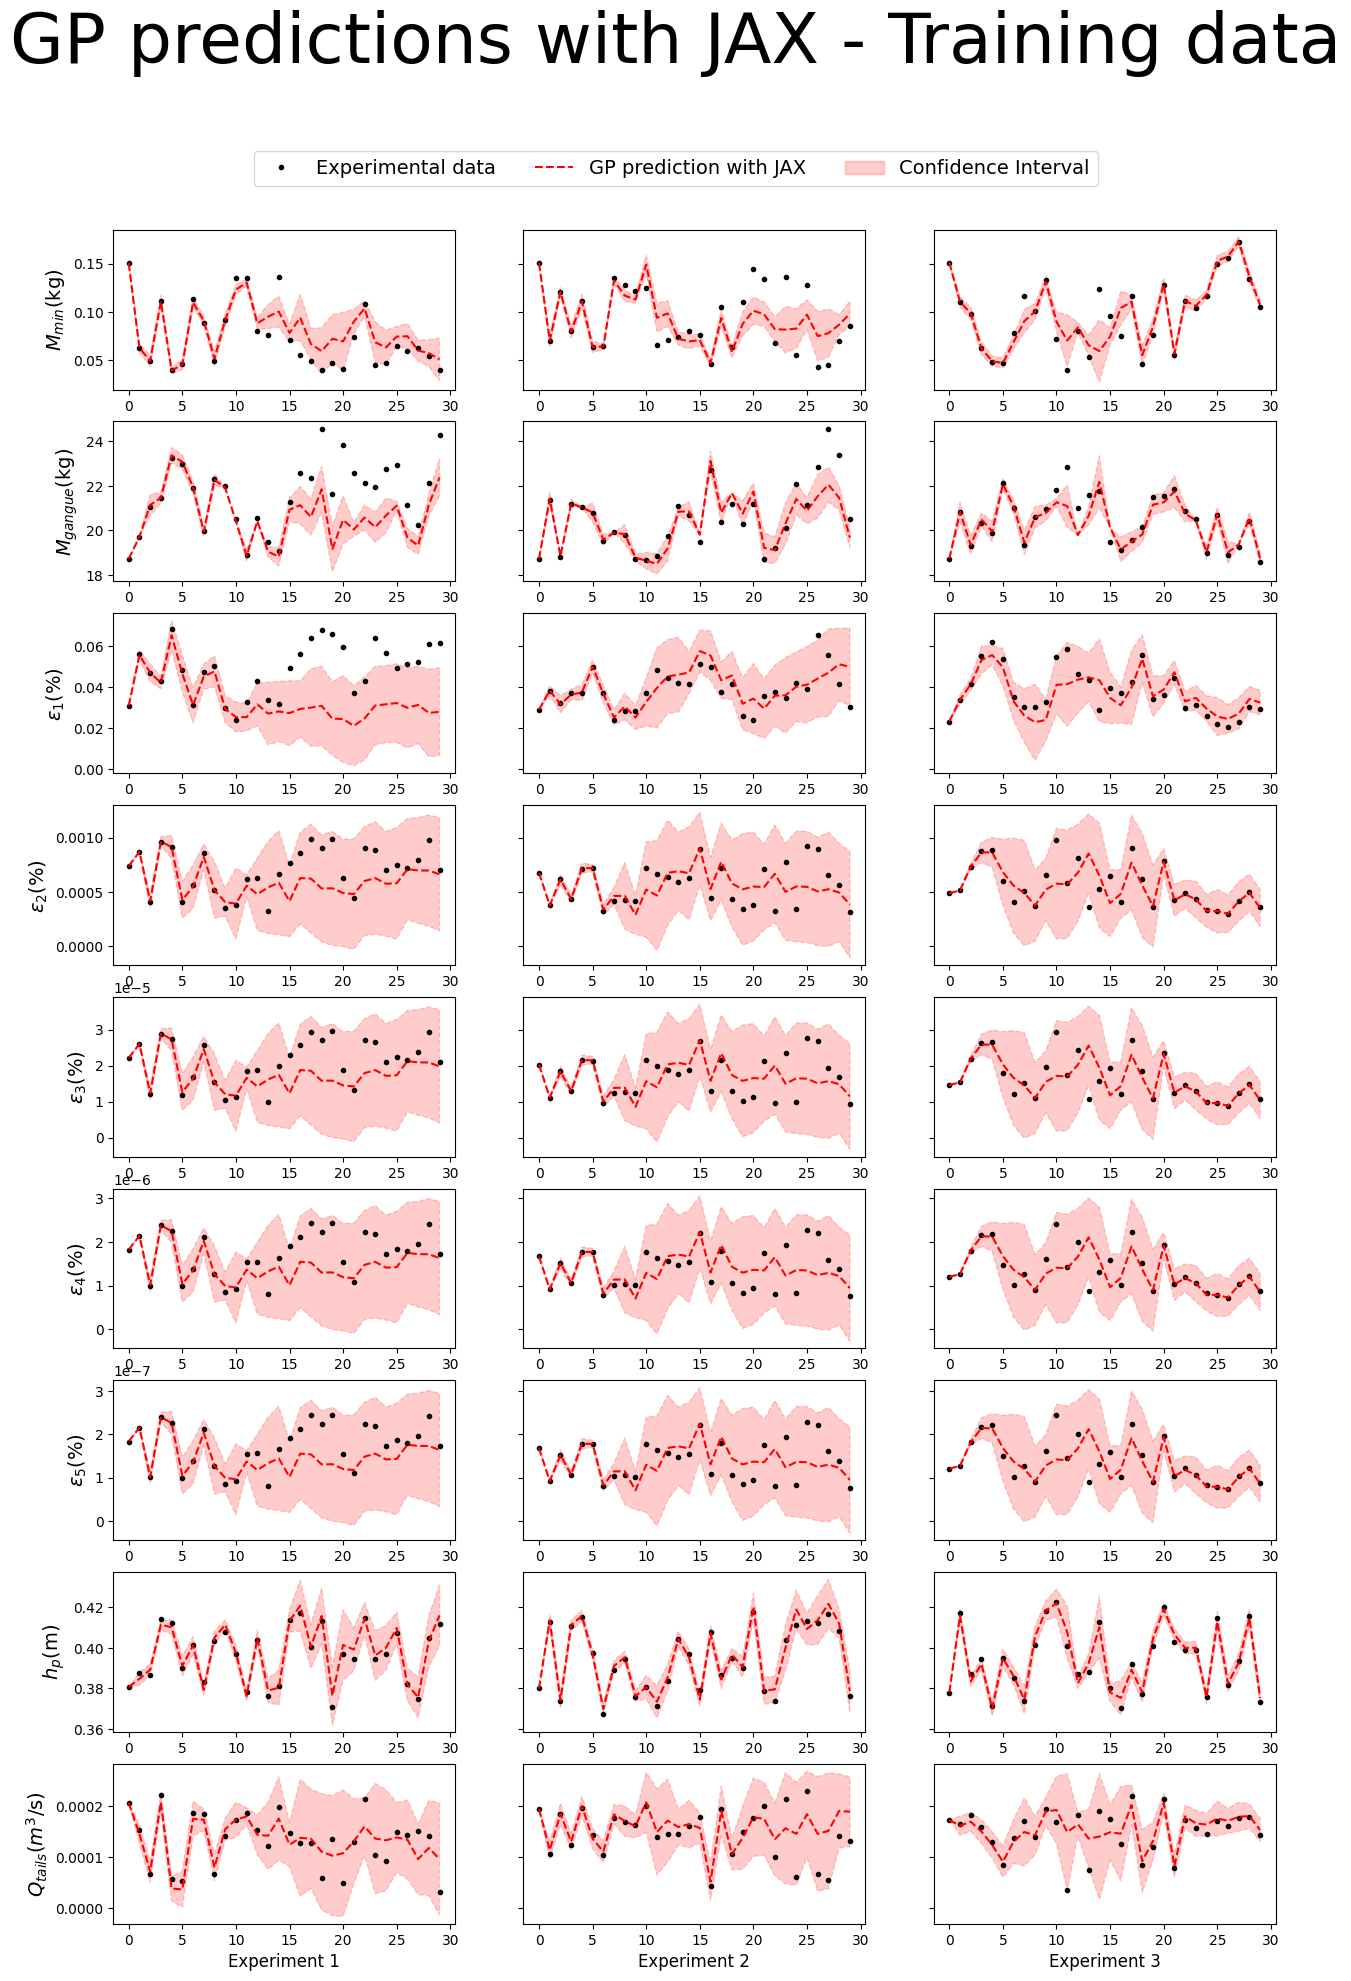

In [267]:
#######################################################
### Plot training data ###
#######################################################

'Extracting Dataset'
dir = os.getcwd()
# go back one folder
dir = os.path.dirname(dir)
# open the folder called Data
dir = os.path.join(dir, 'Data')
file_path_4 = os.path.join(dir, '30State_Traj1_for5min_0405.csv')
file_path_5 = os.path.join(dir, '30State_Traj2_for5min_0405.csv')
file_path_6 = os.path.join(dir, '30State_Traj3_for5min_0405.csv')

df = pd.read_csv(file_path_4)
df.reset_index(drop=True, inplace=True)
data_raw4 = df.values

df = pd.read_csv(file_path_5)
df.reset_index(drop=True, inplace=True)
data_raw5 = df.values

df = pd.read_csv(file_path_6)
df.reset_index(drop=True, inplace=True)
data_raw6 = df.values

'Extracting Variables'
datasets = [data_raw4, data_raw5, data_raw6]
Xdat_list = []
Ydat_list = []
xt_real_list = []
controls_list = []
#xt_list = []
N_state = 30

for data_raw in datasets:
    # Extract indices for every state
    selected_indices = np.arange(0, len(data_raw[:, 0]), 300)[:N_state] #Selected_indices = timestamps for which the sampling was done in the raw data
    data_state = data_raw[selected_indices, :] #Selected all the columns of the sampled rows (every 300th row selectes all the data from all columns)


    Xdat_temp = data_state[:-1, :] #All rows up to the last row and all the columns from the sample dataset
    Ydat_temp = data_state[1:, :-2] - data_state[:-1, :-2] #(All rows except the first one and all columns except the last two). Subtracting each from the row that follows it. The delta.
    controls_temp = data_state[:-1, -2:] # same as Xdat_temp[:,-2:]

    # Append the results to their respective lists
    Xdat_list.append(Xdat_temp)
    Ydat_list.append(Ydat_temp)
    xt_real_list.append(data_state.T)  # Transposed for consistency
    controls_list.append(controls_temp.T)

# Concatenate the lists into single arrays
###### why cant we train it without concatenate??
Xdat = np.concatenate(Xdat_list, axis=0) #Xdat is 29 samples of every column (11) from each of the 3 datasets, because need Ydat and Xdat dimensions to be the same and Ydat is 30-1. Therefore 30-3.
                                         #Xdat shape is (87,11)

Ydat = np.concatenate(Ydat_list, axis=0) #Ydat is the delta between all the states for the 30 samples.
                                         #Ydat shape is (87,9)
xt_real = np.stack(xt_real_list)

#xt_real = np.concatenate(xt_real_list, axis=1)  # Note the axis=1 due to transposition
controls = np.transpose(np.array(controls_list), axes=(1, 0, 2))
# xt = np.concatenate(xt_list, axis=1)


hp_0   = controls[0]
Qair_0 = controls[1] #Samples 300th row 30 times but theres only 29 elements in these lists?


'Plotting Data'


# --- problem parameters --- #
experiments = 3  # number of trajectories
steps_ = (N_state - 1)
nd = 9  # number of state variable
nu = 2  # number of controlled variable
x0 = xt_real[:, 0:-2, 0]  # current state (specified initial state) defined as x0

tt = range(N_state)
# --- input arrays --- # (training)
hp_np = np.array(hp_0)
Qair_np = np.array(Qair_0)

# --- data collectors --- #
Xreal = np.zeros((experiments * steps_, nd + nu))
Yreal = np.zeros((experiments * steps_, nd))
Delta_YmeanGP = np.zeros((experiments, steps_, nd))
Delta_YstdGP = np.zeros((experiments, steps_, nd))

# --- plot options --- #
fig = plt.figure()
fig.set_size_inches(14, 9)
color_cycle = plt.cm.tab10(np.linspace(0, 1, experiments+2))
state_indices = [0,1,2, 3, 4, 5, 6,7,8]


for run_i in range(controls.shape[1]):  # controls.shape[1]= experiment
    GP_run = GP_simulate(GP_m_1, x0[run_i, :], controls[:, run_i, :])
    Delta_YmeanGP[run_i, :, :], Delta_YstdGP[run_i, :, :] = GP_run.multi_step_noprop()
    # print(f'check deltaY {Delta_YmeanGP.shape}')
    
    cumulative_deltaYmean = np.cumsum(Delta_YmeanGP[run_i, :, :], axis=0)
    YmeanGP = cumulative_deltaYmean + x0[run_i, :]
    # print(f'check YmeanGP1 {YmeanGP.shape}')
    
    # Reshape and concatenate to include the initial state
    YmeanGP = np.concatenate([x0[run_i, :].reshape(1, -1), YmeanGP], axis=0)  # final array with shape (steps_ + 1, nd)
    # print(f'check YmeanGP2 {YmeanGP.shape}')

    YstdGP = np.concatenate([np.zeros((1, nd)), Delta_YstdGP[run_i, :, :]], axis=0)
    # print(f'check YstdGP {YstdGP.shape}')

    if run_i == 0:
        # Initialize the final arrays to store results for all experiments
        YmeanGP_m_1 = np.zeros((experiments, steps_ + 1, nd))
        YstdGP_m_1 = np.zeros((experiments, steps_ + 1, nd))

    YmeanGP_m_1[run_i, :, :] = YmeanGP
    YstdGP_m_1[run_i, :, :] = YstdGP


#self.X_norm, self.Y_norm    = (X-self.X_mean)/self.X_std, (Y-self.Y_mean)/self.Y_std

def calculate_rmspe(Y_true, Y_pred):
    return np.sqrt(np.mean(((Y_true - Y_pred) / Y_true)**2)) * 100

# def calculate_Rsquared(Y_true, Y_pred):
#     ss_tot = np.sum((Y_true - np.mean(Y_true))**2)
#     ss_res = np.sum((Y_true - Y_pred)**2)
#     return 1 - (ss_res / ss_tot)

def calculate_nlpd(Y_true, Y_pred, Y_std):
    Y_std = np.maximum(Y_std, 1e-3)
    return np.mean((Y_true - Y_pred)**2 / (2 * Y_std**2) + 0.5 * np.log(2 * np.pi * Y_std**2))

def calculate_mape(Y_true, Y_pred):
    return np.mean(np.abs((Y_true - Y_pred) / Y_true)) * 100

rmspe_gp_m_1 = np.zeros((experiments, len(state_indices)))
# r2_gp_m_1 = np.zeros((experiments, len(state_indices)))
mape_gp_m_1 = np.zeros((experiments, len(state_indices)))
nlpd_gp_m_1 = np.zeros((experiments, len(state_indices)))

for exp in range(experiments):
    for idx, state in enumerate(state_indices):
        #Z-score normalisation
        Y_true = xt_real[exp, :-2, state]
        Y_pred = YmeanGP_m_1[exp, state, :]
        Y_std = np.sqrt(YstdGP_m_1[exp, state, :])

        Y_true_normalised = (Y_true - np.mean(Y_true)) / np.std(Y_true)
        Y_pred_normalised = (Y_pred - np.mean(Y_pred)) / np.std(Y_pred)
        Y_std_normalised = (Y_std) / np.std(Y_pred)

        rmspe_gp_m_1[exp, idx] = calculate_rmspe(Y_true_normalised, Y_pred_normalised)
        # r2_gp_m_1[exp, idx] = calculate_Rsquared(Y_true_normalised, Y_pred_normalised)
        mape_gp_m_1[exp, idx] = calculate_mape(Y_true_normalised, Y_pred_normalised)
        nlpd_gp_m_1[exp, idx] = calculate_nlpd(Y_true_normalised, Y_pred_normalised, Y_std_normalised)

# --- plotting --- #
# Define indices of states to plot

num_states = len(state_indices)

# Define a new set of distinct colors using a colormap
color_cycle = plt.cm.tab10(np.linspace(0, 1, experiments + 8))
# --- plot options --- #
fig, axs = plt.subplots(num_states, experiments,figsize=(15, 22), sharey='row')  # Change to (num_states, experiments)
fig_title = [r'$M_{min}$(kg)', r'$M_{gangue}$(kg)', r'$\varepsilon_1$(%) ', r'$\varepsilon_2$(%) ', r'$\varepsilon_3$(%)', r'$\varepsilon_4$(%)', r'$\varepsilon_5$(%)', r'$h_p$(m)', r'$Q_{tails}$($m^3$/s)']
handles = []
labels = []

for exp in range(experiments):
    for idx, state in enumerate(state_indices):
        ax = axs[idx, exp]  # Access subplot by (state, experiment)

        x_r = xt_real[exp, :-2, :]  # Assuming shape to be (n_vars, n_steps)
        
        # Plot the real system trajectory (dashed line)
        handle_real, = ax.plot(tt, x_r[state, :], '.', label=f'Real data', color='black')
        
        
        # Plot GP_m_1 mean and CI
        handle_gp_m_1, = ax.plot(tt, YmeanGP_m_1[exp, :, state], label=f'GP prediction {exp + 1}', linestyle='--', color='red')
        ax.fill_between(tt, YmeanGP_m_1[exp, :, state] - 2 * np.sqrt(YstdGP_m_1[exp, :, state]),
                        YmeanGP_m_1[exp, :, state] + 2 * np.sqrt(YstdGP_m_1[exp, :, state]),
                        color='red', alpha=0.2, linestyle='--')
        
        if exp == 0:
            ax.set_ylabel(fig_title[state], fontsize=14)  # Set the title as the ylabel for each state

        if idx == num_states - 1:
            ax.set_xlabel(f'Experiment {exp+1}', fontsize=12)


        # Collect handles and labels for legend
        if idx == 0 and exp == 0:
            # Create a custom patch for the confidence region
            confidence_patch = Patch(color='red', alpha=0.2, label='Confidence Interval')
            
            handles.extend([handle_real, handle_gp_m_1, confidence_patch])
            labels.extend([f'Experimental data', 'GP prediction with JAX', 'Confidence Interval'])
    
        # Annotate RMSE, MAE, NLPD
    #ax.text(0.05, 0.85, f'Percentage Error GP: {overall_percentage_error:.2f}%', transform=ax.transAxes, fontsize=10, verticalalignment='top', color='red')
        # ax.text(0.05, 0.75, f'MAE GP: {mae_gp_m_1[exp, idx]:.2f}', transform=ax.transAxes, fontsize=10, verticalalignment='top', color='red')
        # ax.text(0.05, 0.05, f'NLPD GP: {nlpd_gp_m_1[exp, idx]:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top', color='red')
    #fig.text(0.5, -0.05, f'Percentage Error GP: {overall_percentage_error:.2f}%', ha='center', fontsize=12, color='red', transform=plt.gcf().transFigure)
        
        


# Create a single line of text with all experiment annotations
# annotation_text1 = " | ".join([f"Experiment {exp + 1} - RMSE: {np.mean(rmse_gp_m_1[exp]):.6f} "
#                              for exp in range(experiments)])

# annotation_text2 = " | ".join([f"Experiment {exp + 1} - NLPD: {np.mean(nlpd_gp_m_1[exp]):.2f} "
#                              for exp in range(experiments)])

# annotation_text3 = " | ".join([f"Experiment {exp + 1} - R^2: {np.mean(r2_gp_m_1[exp]):.8f} "
#                              for exp in range(experiments)])

# To add text at the bottom
# fig.text(0.5, -0.05, annotation_text1, ha='center', fontsize=12, color='red', transform=plt.gcf().transFigure)
# fig.text(0.5, -0.07, annotation_text2, ha='center', fontsize=12, color='red', transform=plt.gcf().transFigure)
# fig.text(0.5, -0.09, annotation_text3, ha='center', fontsize=12, color='red', transform=plt.gcf().transFigure)

# Add a single legend outside the subplots
fig.suptitle('GP predictions with JAX - Training data', fontsize=50, ha='center')

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.92), ncol=3, fontsize=14)

for exp in range(experiments):
    print (f"Experiment {exp + 1} - RMSPE: {np.mean(rmspe_gp_m_1[exp]):.2f} % ")
    print (f"Experiment {exp + 1} - NLPD: {np.mean(nlpd_gp_m_1[exp]):.2f} ")
    # print (f"Experiment {exp + 1} - R^2: {np.mean(r2_gp_m_1[exp]):.8f} ")
    print (f"Experiment {exp + 1} - MAPE: {np.mean(mape_gp_m_1[exp]):.2f} % ")


# Plotting Testing Data Performance

/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:254: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(threshold, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error --> adjusted to add threshold instead of 0


Experiment 1 - RMSPE: 0.40 % 
Experiment 1 - NLPD: -4.78 
Experiment 1 - MAPE: 0.26 % 
Experiment 2 - RMSPE: 0.40 % 
Experiment 2 - NLPD: -4.79 
Experiment 2 - MAPE: 0.28 % 
Experiment 3 - RMSPE: 0.63 % 
Experiment 3 - NLPD: -4.17 
Experiment 3 - MAPE: 0.44 % 


<Figure size 1400x900 with 0 Axes>

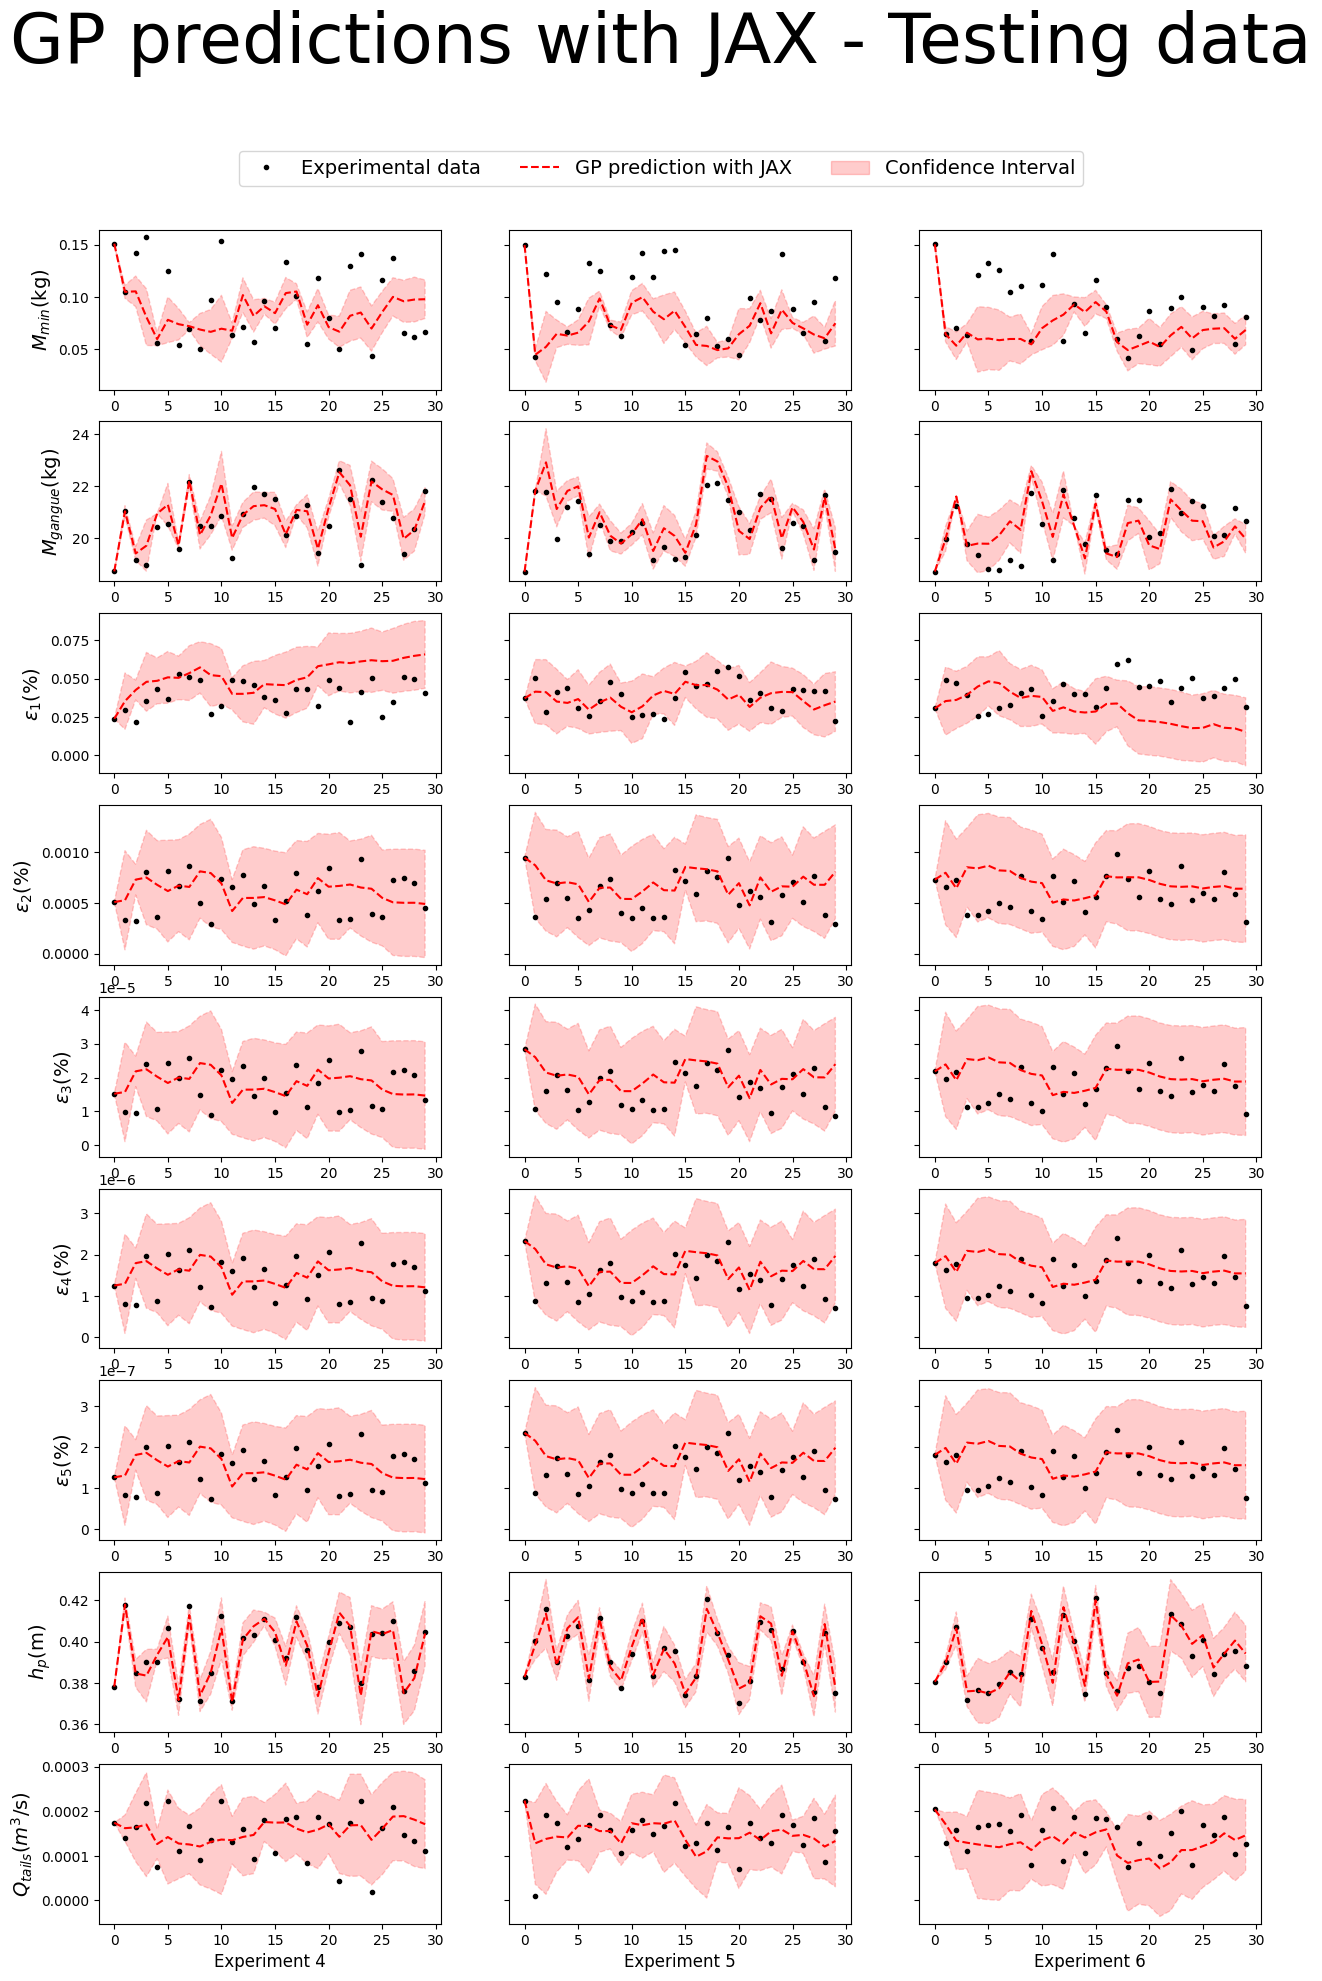

In [268]:
'Extracting Dataset'
dir = os.getcwd()
# go back one folder
dir = os.path.dirname(dir)
# open the folder called Data
dir = os.path.join(dir, 'Data')
file_path_7 = os.path.join(dir, '30State_Traj4_for5min_0405.csv')
file_path_8 = os.path.join(dir, '30State_Traj5_for5min_0405.csv')
file_path_9 = os.path.join(dir, '30State_Traj6_for5min_0405.csv')

df = pd.read_csv(file_path_7)
df.reset_index(drop=True, inplace=True)
data_raw7 = df.values

df = pd.read_csv(file_path_8)
df.reset_index(drop=True, inplace=True)
data_raw8 = df.values

df = pd.read_csv(file_path_9)
df.reset_index(drop=True, inplace=True)
data_raw9 = df.values

'Extracting Variables'
datasets = [data_raw7, data_raw8, data_raw9]
Xdat_list = []
Ydat_list = []
xt_real_list = []
controls_list = []
#xt_list = []
N_state = 30

for data_raw in datasets:
    # Extract indices for every state
    selected_indices = np.arange(0, len(data_raw[:, 0]), 300)[:N_state] #Selected_indices = timestamps for which the sampling was done in the raw data
    data_state = data_raw[selected_indices, :] #Selected all the columns of the sampled rows (every 300th row selectes all the data from all columns)


    Xdat_temp = data_state[:-1, :] #All rows up to the last row and all the columns from the sample dataset
    Ydat_temp = data_state[1:, :-2] - data_state[:-1, :-2] #(All rows except the first one and all columns except the last two). Subtracting each from the row that follows it. The delta.
    controls_temp = data_state[:-1, -2:] # same as Xdat_temp[:,-2:]

    # Append the results to their respective lists
    Xdat_list.append(Xdat_temp)
    Ydat_list.append(Ydat_temp)
    xt_real_list.append(data_state.T)  # Transposed for consistency
    controls_list.append(controls_temp.T)

# Concatenate the lists into single arrays
###### why cant we train it without concatenate??
Xdat = np.concatenate(Xdat_list, axis=0) #Xdat is 29 samples of every column (11) from each of the 3 datasets, because need Ydat and Xdat dimensions to be the same and Ydat is 30-1. Therefore 30-3.
                                         #Xdat shape is (87,11)

Ydat = np.concatenate(Ydat_list, axis=0) #Ydat is the delta between all the states for the 30 samples.
                                         #Ydat shape is (87,9)
xt_real = np.stack(xt_real_list)

#xt_real = np.concatenate(xt_real_list, axis=1)  # Note the axis=1 due to transposition
controls = np.transpose(np.array(controls_list), axes=(1, 0, 2))
# xt = np.concatenate(xt_list, axis=1)


hp_0   = controls[0]
Qair_0 = controls[1] #Samples 300th row 30 times but theres only 29 elements in these lists?


'Plotting Data'


# --- problem parameters --- #
experiments = 3  # number of trajectories
steps_ = (N_state - 1)
nd = 9  # number of state variable
nu = 2  # number of controlled variable
x0 = xt_real[:, 0:-2, 0]  # current state (specified initial state) defined as x0

tt = range(N_state)
# --- input arrays --- # (training)
hp_np = np.array(hp_0)
Qair_np = np.array(Qair_0)

# --- data collectors --- #
Xreal = np.zeros((experiments * steps_, nd + nu))
Yreal = np.zeros((experiments * steps_, nd))
Delta_YmeanGP = np.zeros((experiments, steps_, nd))
Delta_YstdGP = np.zeros((experiments, steps_, nd))

# --- plot options --- #
fig = plt.figure()
fig.set_size_inches(14, 9)
color_cycle = plt.cm.tab10(np.linspace(0, 1, experiments+2))
state_indices = [0,1,2, 3, 4, 5, 6,7,8]



for run_i in range(controls.shape[1]):  # controls.shape[1]= experiment
    GP_run = GP_simulate(GP_m_1, x0[run_i, :], controls[:, run_i, :])
    Delta_YmeanGP[run_i, :, :], Delta_YstdGP[run_i, :, :] = GP_run.multi_step_noprop()
    # print(f'check deltaY {Delta_YmeanGP.shape}')
    
    cumulative_deltaYmean = np.cumsum(Delta_YmeanGP[run_i, :, :], axis=0)
    YmeanGP = cumulative_deltaYmean + x0[run_i, :]
    # print(f'check YmeanGP1 {YmeanGP.shape}')
    
    # Reshape and concatenate to include the initial state
    YmeanGP = np.concatenate([x0[run_i, :].reshape(1, -1), YmeanGP], axis=0)  # final array with shape (steps_ + 1, nd)
    # print(f'check YmeanGP2 {YmeanGP.shape}')

    YstdGP = np.concatenate([np.zeros((1, nd)), Delta_YstdGP[run_i, :, :]], axis=0)
    # print(f'check YstdGP {YstdGP.shape}')

    if run_i == 0:
        # Initialize the final arrays to store results for all experiments
        YmeanGP_m_1 = np.zeros((experiments, steps_ + 1, nd))
        YstdGP_m_1 = np.zeros((experiments, steps_ + 1, nd))

    YmeanGP_m_1[run_i, :, :] = YmeanGP
    YstdGP_m_1[run_i, :, :] = YstdGP


def calculate_rmspe(Y_true, Y_pred):
    return np.sqrt(np.mean(((Y_true - Y_pred) / Y_true)**2)) * 100

# def calculate_Rsquared(Y_true, Y_pred):
#     ss_tot = np.sum((Y_true - np.mean(Y_true))**2)
#     ss_res = np.sum((Y_true - Y_pred)**2)
#     return 1 - (ss_res / ss_tot)

def calculate_nlpd(Y_true, Y_pred, Y_std):
    Y_std = np.maximum(Y_std, 1e-3)
    return np.mean((Y_true - Y_pred)**2 / (2 * Y_std**2) + 0.5 * np.log(2 * np.pi * Y_std**2))

def calculate_mape(Y_true, Y_pred):
    return np.mean(np.abs((Y_true - Y_pred) / Y_true)) * 100

rmspe_gp_m_1 = np.zeros((experiments, len(state_indices)))
# r2_gp_m_1 = np.zeros((experiments, len(state_indices)))
mape_gp_m_1 = np.zeros((experiments, len(state_indices)))
nlpd_gp_m_1 = np.zeros((experiments, len(state_indices)))

for exp in range(experiments):
    for idx, state in enumerate(state_indices):
        #Z-score normalisation
        Y_true = xt_real[exp, :-2, state]
        Y_pred = YmeanGP_m_1[exp, state, :]
        Y_std = np.sqrt(YstdGP_m_1[exp, state, :])

        Y_true_normalised = (Y_true - np.mean(Y_true)) / np.std(Y_true)
        Y_pred_normalised = (Y_pred - np.mean(Y_pred)) / np.std(Y_pred)
        Y_std_normalised = (Y_std) / np.std(Y_pred)

        rmspe_gp_m_1[exp, idx] = calculate_rmspe(Y_true_normalised, Y_pred_normalised)
        # r2_gp_m_1[exp, idx] = calculate_Rsquared(Y_true_normalised, Y_pred_normalised)
        mape_gp_m_1[exp, idx] = calculate_mape(Y_true_normalised, Y_pred_normalised)
        nlpd_gp_m_1[exp, idx] = calculate_nlpd(Y_true_normalised, Y_pred_normalised, Y_std_normalised)

# --- plotting --- #
# Define indices of states to plot

num_states = len(state_indices)

# Define a new set of distinct colors using a colormap
color_cycle = plt.cm.tab10(np.linspace(0, 1, experiments + 8))
# --- plot options --- #
fig, axs = plt.subplots(num_states, experiments,figsize=(15, 22), sharey='row')  # Change to (num_states, experiments)
fig_title = [r'$M_{min}$(kg)', r'$M_{gangue}$(kg)', r'$\varepsilon_1$(%) ', r'$\varepsilon_2$(%) ', r'$\varepsilon_3$(%)', r'$\varepsilon_4$(%)', r'$\varepsilon_5$(%)', r'$h_p$(m)', r'$Q_{tails}$($m^3$/s)']
handles = []
labels = []

for exp in range(experiments):
    for idx, state in enumerate(state_indices):
        ax = axs[idx, exp]  # Access subplot by (state, experiment)

        x_r = xt_real[exp, :-2, :]  # Assuming shape to be (n_vars, n_steps)
        
        # Plot the real system trajectory (dashed line)
        handle_real, = ax.plot(tt, x_r[state, :], '.', label=f'Real data', color='black')
        
        
        # Plot GP_m_1 mean and CI
        handle_gp_m_1, = ax.plot(tt, YmeanGP_m_1[exp, :, state], label=f'GP prediction {exp + 1}', linestyle='--', color='red')
        ax.fill_between(tt, YmeanGP_m_1[exp, :, state] - 2 * np.sqrt(YstdGP_m_1[exp, :, state]),
                        YmeanGP_m_1[exp, :, state] + 2 * np.sqrt(YstdGP_m_1[exp, :, state]),
                        color='red', alpha=0.2, linestyle='--')
        
        if exp == 0:
            ax.set_ylabel(fig_title[state], fontsize=14)  # Set the title as the ylabel for each state

        if idx == num_states - 1:
            ax.set_xlabel(f'Experiment {exp+4}', fontsize=12)


        # Collect handles and labels for legend
        if idx == 0 and exp == 0:
            # Create a custom patch for the confidence region
            confidence_patch = Patch(color='red', alpha=0.2, label='Confidence Interval')
            
            handles.extend([handle_real, handle_gp_m_1, confidence_patch])
            labels.extend([f'Experimental data', 'GP prediction with JAX', 'Confidence Interval'])
    
        # Annotate RMSE, MAE, NLPD
    #ax.text(0.05, 0.85, f'Percentage Error GP: {overall_percentage_error:.2f}%', transform=ax.transAxes, fontsize=10, verticalalignment='top', color='red')
        # ax.text(0.05, 0.75, f'MAE GP: {mae_gp_m_1[exp, idx]:.2f}', transform=ax.transAxes, fontsize=10, verticalalignment='top', color='red')
        # ax.text(0.05, 0.05, f'NLPD GP: {nlpd_gp_m_1[exp, idx]:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top', color='red')
    #fig.text(0.5, -0.05, f'Percentage Error GP: {overall_percentage_error:.2f}%', ha='center', fontsize=12, color='red', transform=plt.gcf().transFigure)
        
        


# Create a single line of text with all experiment annotations
# annotation_text1 = " | ".join([f"Experiment {exp + 1} - RMSE: {np.mean(rmse_gp_m_1[exp]):.6f} "
#                              for exp in range(experiments)])

# annotation_text2 = " | ".join([f"Experiment {exp + 1} - NLPD: {np.mean(nlpd_gp_m_1[exp]):.2f} "
#                              for exp in range(experiments)])

# annotation_text3 = " | ".join([f"Experiment {exp + 1} - R^2: {np.mean(r2_gp_m_1[exp]):.8f} "
#                              for exp in range(experiments)])

# To add text at the bottom
# fig.text(0.5, -0.05, annotation_text1, ha='center', fontsize=12, color='red', transform=plt.gcf().transFigure)
# fig.text(0.5, -0.07, annotation_text2, ha='center', fontsize=12, color='red', transform=plt.gcf().transFigure)
# fig.text(0.5, -0.09, annotation_text3, ha='center', fontsize=12, color='red', transform=plt.gcf().transFigure)

# Add a single legend outside the subplots
fig.suptitle('GP predictions with JAX - Testing data', fontsize=50, ha='center')

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.92), ncol=3, fontsize=14)

for exp in range(experiments):
    print (f"Experiment {exp + 1} - RMSPE: {np.mean(rmspe_gp_m_1[exp]):.2f} % ")
    print (f"Experiment {exp + 1} - NLPD: {np.mean(nlpd_gp_m_1[exp]):.2f} ")
    # print (f"Experiment {exp + 1} - R^2: {np.mean(r2_gp_m_1[exp]):.8f} ")
    print (f"Experiment {exp + 1} - MAPE: {np.mean(mape_gp_m_1[exp]):.2f} % ")

In [269]:
# plot for cross-validation (need to include due to manipulation of xt_real)

dir = os.getcwd()
# go back one folder
dir = os.path.dirname(dir)
# go to the data folder
dir = os.path.join(dir, 'Data')
file_path_1 = os.path.join(dir, '30State_Traj4_for5min_0405.csv')


df  = pd.read_csv(file_path_1)
df.reset_index(drop=True, inplace=True)
data_raw = df.values
#data_raw = np.concatenate([data_raw[:, 0:3], data_raw[:, -2:]], axis=1)

# extract for every state (every 300 seconds)
N_state = 30
# still only have 30 points for every trajectory
selected_indices = np.arange(0,size(data_raw[:,0]),300)[:N_state] #added [:30] to take only 30 points, in case we are working with 100 states
data_state = data_raw[selected_indices,:]

# Prepare Xdat and Ydat based on state
Ydat = data_state[1:,:-2]-data_state[:-1,:-2]
Xdat = data_state[:-1,:]

# set xt and xt_real for convience and keep consistent with the code in GP model
xt_real = data_state.T
hp_0 = xt_real[-2, :]
Qair_0 = xt_real[-1, :]

In [270]:
from scipy.optimize import differential_evolution, basinhopping
 

## MPC model

In [274]:
steps_ = 29
nd = 9
nu = 2
mpc_iters = steps_ 
mpc_runs_n = 1
controls = np.array([hp_0[:-1],Qair_0[:-1]]) # shape (nu, steps)
x00          = xt_real[0:-2,0]
horizon = 5 #control horizon
initial_guess = [[np.mean(hp_0[1:]), np.mean(Qair_0[1:])] * (horizon)]
initial_guess = np.array(initial_guess).reshape((horizon*nu))


# hp between 0.37 and 0.42 [metres]; Qair between 9x10^-4 and 3x10^-3 [m^3/s]
control_lb = np.array([0.37, 9*10**(-4)]*(horizon))
control_ub = np.array([0.42, 3*10**(-3)]*(horizon))
control_bounds = np.hstack((control_lb.reshape(horizon*nu,1), control_ub.reshape(horizon*nu, 1)))


def obj_func(controls, x0, horizon, damping_factor): #control here is only within the control_horizon of 5
  # Controls: repeat hp2 and Qair2 three more times ([0,1,2,2,2]) for control stability
  controls = controls.reshape((nu, horizon), order='F')
  controls[:, 3] = controls[:, 2]
  controls[:, 4] = controls[:, 2]

  #print(f'check control {controls}')
  #print(f'check control shape{controls.shape}')

  experiments = 1 # only have one experiment, so no loop here

  #compute GP model prediction for horizon
  # --- data collectors --- #
  Delta_YmeanGP = np.zeros((experiments, horizon, nd))
  Delta_YstdGP  = np.zeros((experiments, horizon, nd))
  # --- run GP model --- #
  GP_run                                = GP_simulate(GP_m_1, x0, controls[:,:])
  Delta_YmeanGP[:,:], Delta_YstdGP[:,:] = GP_run.multi_step_noprop()
  #Delta_YmeanGP and Delta_YstdGP are both numpy arrays

  cumulative_deltaYmean = np.cumsum(Delta_YmeanGP[:,:,:], axis=1) #(1, 5, 8)
  YmeanGP = cumulative_deltaYmean + x0
  YmeanGP = np.vstack((x0, YmeanGP[0,:,:])) #(6,8)
  YmeanGP = YmeanGP.reshape(experiments, horizon+1, nd) #(1,6,9) reshape the size for dimension convience, not nescessary
  YstdGP  = np.vstack((np.zeros((x0.shape)), Delta_YstdGP[0,:,:]))
  YstdGP  = YstdGP.reshape(experiments, horizon+1, nd) #(1,6,9) 

  max_vals = np.max(YstdGP[0,:,:], axis=0) #Smallest values produed from ystdGP seems to be around 1e-15


  YstdGP_normalized = YstdGP / (max_vals) 
  YstdGP_hp = YstdGP[0,1,7]
  std_penalty = np.sum(YstdGP_normalized[0,1,:]) 
  #print(f'std_penalty {std_penalty}') 


  # --- calculate objective --- #
  Delta_u = controls[:,:-1] - controls[:,1:] #(2,4)
  #print(f'check deltaU {Delta_u.shape}')
  Q = np.array([[100,0],[0,10**(6)]])
  u_penalty = (np.sum(Delta_u.T@Q@Delta_u))    #u_penalty = (Delta_u.T@Q@Delta_u) dimension issue. #check it should be always positive
  
  # Add a damping penalty that increases with each iteration
  iteration_number = np.arange(len(Delta_u[0]))  # Assuming each column is an iteration step
  damping_penalty = damping_factor * np.sum((iteration_number * Delta_u)**2)
  
  
  #Potentially change to delta U
    
  #print(f'u_penalty {u_penalty}')

  #calculate the return_term
  Mmin_final = YmeanGP[0,-1,0]
  hp         = YmeanGP[0,-1,7]
  hp_firststep = YmeanGP[0,1,7]
  total_epsilon = np.sum(YmeanGP[0,-1,2:6])
  A_cell = 0.181 # A_cell is the cross-sectional tank area
  C1_tails = Mmin_final/(hp*(1-total_epsilon)*A_cell) #threshold of control behaviour

  # make penalty term has the same order of magnitude as C1_tails
  '''
  if u_penalty != 0:
    factor = 10**(math.log10(C1_tails) - math.log10((u_penalty))) #
    #print(f'factor {factor}')
    u_penalty *= (factor/10000) # as u_penalty is some order of magnitude smaller than Mmin
  '''
  return (C1_tails * 300) + ((u_penalty*damping_penalty) * 0.1)  + (std_penalty*0.03)  , C1_tails, u_penalty, std_penalty, Mmin_final, hp, hp_firststep, YstdGP_hp, total_epsilon

def wrapper_func(controls, x0, horizon, damping_factor):
      return obj_func(controls, x0, horizon, damping_factor)[0]

def choose_uk(obj_func, controls, x0, horizon, initial_guess, control_bounds):
  # Wrap the objective function to only return the first output to minimize
  
  result = minimize(wrapper_func, args=(x0, horizon, damping_factor), x0=initial_guess,
                   bounds=control_bounds, method = 'COBYQA') # method = 'SLSQP' Result of this minimisation is the control (uk)

  # result = differential_evolution(wrapper_func, bounds=control_bounds, args=(x0,horizon,damping_factor), maxiter=10, popsize=15)
 
#xnew = res.x
 
  # Call obj_func one more time to get the detailed results for logging
  _, C1_tails, u_penalty, std_penalty, Mmin_final, hp, hp_firststep, YstdGP_hp, total_epsilon = obj_func(result.x, x0, horizon, damping_factor)
      
  return result.x, C1_tails, u_penalty, std_penalty, Mmin_final, hp, hp_firststep, YstdGP_hp, total_epsilon


# == lists to compile results == #
data_mpc           = {}
data_mpc['X_list'] = np.zeros((nd, mpc_iters+1, mpc_runs_n))
data_mpc['U_list'] = np.zeros((nu, mpc_iters, mpc_runs_n))
#collect the value to plot later and track
C1_tails_values = []
u_penalty_values  = []
std_penalty_values  = []
YstdGP_hp_values = []
Mmin_final_values = []
hp_values = []
hp_firststep_values = []
total_epsilon_values = []
obj_func_values = []

for runs_j in range(mpc_runs_n):
    # initial state
    xk                             = x00
    data_mpc['X_list'][:,0,runs_j] = xk

    #print(f'check initial guess for run{runs_j}: {initial_guess}')

    # iteration counter
    if runs_j%5==0:
        print('iteration ',runs_j,' of ',mpc_runs_n)

    # iteration of MPC
    for mpc_i in range(mpc_iters): # in the range of total steps
        #setpoint
        start_time = time.time()
        xs = controls[:,mpc_i:min(mpc_i+horizon, mpc_iters)+1]
        if xs.shape[1]<(horizon+1):
            h_c = horizon-xs.shape[1]+1
            h_c = np.array([xs[:,-1] for i in range(h_c)])
            xs = np.hstack((xs, h_c.T)) #control (make sure it has 5 points as required by horizon=5)
        
        damping_factor = 350
        uk, C1_tails, u_penalty, std_penalty, Mmin_final, hp, hp_firststep, YstdGP_hp, total_epsilon  = choose_uk(obj_func, xs, xk, horizon, initial_guess, control_bounds)# uk = [hp_0, Qair_0, hp_1, Qair_1, ..., hp_4, Qair_4]
        
        print('|||||||||||ITERATION', mpc_i +1, 'of',mpc_iters,'|||||||||||')
        print("State Check:", xk)
        print("Control Check", uk)
        print(f'check C1_talis {C1_tails}')
        print(f'check u_penalty {u_penalty}')
        print(f'check std_penalty {std_penalty}')
        print('State Change Check:', xk)

        C1_tails_values.append(C1_tails)
        u_penalty_values.append(u_penalty)
        std_penalty_values.append(std_penalty)
        YstdGP_hp_values.append(YstdGP_hp)
        Mmin_final_values.append(Mmin_final)
        hp_values.append(hp)
        hp_firststep_values.append(hp_firststep)
        total_epsilon_values.append(total_epsilon)
        obj_func_values.append(C1_tails * 500 + u_penalty*0.01 + std_penalty*0.03)
        
        
        #print(f'uk shape {uk.shape}')
        #update initial guess for next call
        initial_guess = np.hstack((uk[:8], uk[6:8])) #[1, 2, 3, 4, 4]
        
        uk = uk[:2] # [hp_0, Qair_0] only extract the next control action      
        hp_ctrl = uk[0]  
        Qair_ctrl = uk[1]  
        
        M_min_0 = xk[0]
        M_gangue_0 = xk[1]
        Epsilon1_0 = xk[2]
        Epsilon2_0 = xk[3]
        Epsilon3_0 = xk[4]
        Epsilon4_0 = xk[5]
        Epsilon5_0 = xk[6]
        hp_gp_0 = xk[7]
        Qtails_0 = xk[8]
        
        hp_ctrl = float(hp_ctrl)
        Qair_ctrl = float(Qair_ctrl)
        M_min_0 = float(M_min_0)
        M_gangue_0 = float(M_gangue_0)
        Epsilon1_0 = float(Epsilon1_0)
        Epsilon2_0 = float(Epsilon2_0)
        Epsilon3_0 = float(Epsilon3_0)
        Epsilon4_0 = float(Epsilon4_0)
        Epsilon5_0 = float(Epsilon5_0)
        hp_gp_0 = float(hp_gp_0)
        Qtails_0 = float(Qtails_0)

        # Call the MATLAB function and retrieve the outputs
        eng = matlab.engine.start_matlab()
        dir = os.getcwd()
        eng.addpath(dir)
        directory = os.path.join(dir, 'Matlab')
        eng.cd(directory)
        M_min_real, M_gangue_real, Epsilon_real, hp_real, Qtails_real= eng.main_data_generation_func_for_python(hp_ctrl, Qair_ctrl, M_min_0, M_gangue_0, Epsilon1_0,Epsilon2_0,Epsilon3_0,Epsilon4_0,Epsilon5_0, hp_gp_0, Qtails_0, nargout=5)
        eng.quit()
        xk = np.concatenate((np.array([[M_min_real]]), np.array([[M_gangue_real]]), np.array(Epsilon_real), np.array([[hp_real]]), np.array([[Qtails_real]])), axis=1)
        xk = np.squeeze(xk)
        
        #print(f'check xk shape {xk.shape} and type {type(xk)}')
        data_mpc['U_list'][:,mpc_i,runs_j]   = uk #Controls
        data_mpc['X_list'][:,mpc_i+1,runs_j] = xk #States

        end_time = time.time()
        time_taken = end_time - start_time
        print ("Iteration",mpc_i+1,"Took", time_taken, "seconds")



iteration  0  of  1


/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:254: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(threshold, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error --> adjusted to add threshold instead of 0


|||||||||||ITERATION 1 of 29 |||||||||||
State Check: [1.50961684e-01 1.87380049e+01 2.37945688e-02 5.06882335e-04
 1.52068894e-05 1.24873027e-06 1.25910300e-07 3.78224602e-01
 1.74056474e-04]
Control Check [0.39409636 0.003      0.39569763 0.00292397 0.39593541 0.00299932
 0.39593541 0.00299932 0.39593541 0.00299932]
check C1_talis 1.0324585104680948
check u_penalty 0.00033867180962916365
check std_penalty 7.78385616251817
State Change Check: [1.50961684e-01 1.87380049e+01 2.37945688e-02 5.06882335e-04
 1.52068894e-05 1.24873027e-06 1.25910300e-07 3.78224602e-01
 1.74056474e-04]
Iteration 1 Took 16.2799289226532 seconds


/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:254: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(threshold, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error --> adjusted to add threshold instead of 0


|||||||||||ITERATION 2 of 29 |||||||||||
State Check: [7.04939616e-02 2.06160898e+01 7.08772121e-02 1.00041846e-03
 2.98984201e-05 2.45462695e-06 2.47482257e-07 3.94093538e-01
 2.59602240e-04]
Control Check [0.39303867 0.0029994  0.39552223 0.00296775 0.40275384 0.003
 0.40275384 0.003      0.40275384 0.003     ]
check C1_talis 0.592691551215974
check u_penalty 0.009438805670190752
check std_penalty 9.0
State Change Check: [7.04939616e-02 2.06160898e+01 7.08772121e-02 1.00041846e-03
 2.98984201e-05 2.45462695e-06 2.47482257e-07 3.94093538e-01
 2.59602240e-04]
Iteration 2 Took 14.474786758422852 seconds


/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:254: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(threshold, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error --> adjusted to add threshold instead of 0


|||||||||||ITERATION 3 of 29 |||||||||||
State Check: [7.02083111e-02 2.11176532e+01 7.08604646e-02 1.00020303e-03
 2.98919883e-05 2.45409891e-06 2.47429017e-07 3.93038824e-01
 2.61116817e-04]
Control Check [0.39307616 0.0027883  0.39634753 0.00299976 0.40272283 0.003
 0.40272283 0.003      0.40272283 0.003     ]
check C1_talis 0.6016582368104707
check u_penalty 0.05412150182287993
check std_penalty 9.0
State Change Check: [7.02083111e-02 2.11176532e+01 7.08604646e-02 1.00020303e-03
 2.98919883e-05 2.45409891e-06 2.47429017e-07 3.93038824e-01
 2.61116817e-04]
Iteration 3 Took 14.711763858795166 seconds


/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:254: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(threshold, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error --> adjusted to add threshold instead of 0


|||||||||||ITERATION 4 of 29 |||||||||||
State Check: [7.70740715e-02 2.10511089e+01 6.50133938e-02 9.24583982e-04
 2.76344957e-05 2.26876697e-06 2.28743386e-07 3.93076263e-01
 2.77068355e-04]
Control Check [0.39363833 0.00276098 0.39869169 0.003      0.4027287  0.003
 0.4027287  0.003      0.4027287  0.003     ]
check C1_talis 0.5762012302651494
check u_penalty 0.06539177498061874
check std_penalty 9.0
State Change Check: [7.70740715e-02 2.10511089e+01 6.50133938e-02 9.24583982e-04
 2.76344957e-05 2.26876697e-06 2.28743386e-07 3.93076263e-01
 2.77068355e-04]
Iteration 4 Took 14.103909015655518 seconds


/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:254: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(threshold, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error --> adjusted to add threshold instead of 0


|||||||||||ITERATION 5 of 29 |||||||||||
State Check: [7.80738608e-02 2.10070973e+01 6.42683978e-02 9.14866161e-04
 2.73443581e-05 2.24494766e-06 2.26341863e-07 3.93638376e-01
 2.78372882e-04]
Control Check [0.39495235 0.00273122 0.39871735 0.003      0.40255396 0.003
 0.40255396 0.003      0.40255396 0.003     ]
check C1_talis 0.5744396681176819
check u_penalty 0.07802302462617908
check std_penalty 9.0
State Change Check: [7.80738608e-02 2.10070973e+01 6.42683978e-02 9.14866161e-04
 2.73443581e-05 2.24494766e-06 2.26341863e-07 3.93638376e-01
 2.78372882e-04]
Iteration 5 Took 13.902093887329102 seconds


/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:254: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(threshold, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error --> adjusted to add threshold instead of 0


|||||||||||ITERATION 6 of 29 |||||||||||
State Check: [7.91132611e-02 2.10414673e+01 6.34595647e-02 9.04294178e-04
 2.70287111e-05 2.21903411e-06 2.23729193e-07 3.94952453e-01
 2.79055903e-04]
Control Check [0.39721044 0.00257772 0.39837993 0.003      0.4026134  0.003
 0.4026134  0.003      0.4026134  0.003     ]
check C1_talis 0.5701384579185319
check u_penalty 0.18124275060697126
check std_penalty 9.0
State Change Check: [7.91132611e-02 2.10414673e+01 6.34595647e-02 9.04294178e-04
 2.70287111e-05 2.21903411e-06 2.23729193e-07 3.94952453e-01
 2.79055903e-04]
Iteration 6 Took 14.835875749588013 seconds


/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:254: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(threshold, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error --> adjusted to add threshold instead of 0


|||||||||||ITERATION 7 of 29 |||||||||||
State Check: [8.49572041e-02 2.10236059e+01 5.93372290e-02 8.50064036e-04
 2.54094499e-05 2.08609794e-06 2.10326230e-07 3.97210568e-01
 2.86989075e-04]
Control Check [0.39795395 0.00274427 0.39759488 0.00290241 0.40261022 0.003
 0.40261022 0.003      0.40261022 0.003     ]
check C1_talis 0.5479759234286136
check u_penalty 0.0675681121628411
check std_penalty 9.0
State Change Check: [8.49572041e-02 2.10236059e+01 5.93372290e-02 8.50064036e-04
 2.54094499e-05 2.08609794e-06 2.10326230e-07 3.97210568e-01
 2.86989075e-04]
Iteration 7 Took 15.085577964782715 seconds


/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:254: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(threshold, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error --> adjusted to add threshold instead of 0


|||||||||||ITERATION 8 of 29 |||||||||||
State Check: [7.85661493e-02 2.11916832e+01 6.38137383e-02 9.08926276e-04
 2.71670124e-05 2.23038818e-06 2.24873940e-07 3.97953727e-01
 2.74808458e-04]
Control Check [0.39833657 0.00282675 0.39866291 0.003      0.40246637 0.003
 0.40246637 0.003      0.40246637 0.003     ]
check C1_talis 0.5721666894217279
check u_penalty 0.03172081262723045
check std_penalty 9.0
State Change Check: [7.85661493e-02 2.11916832e+01 6.38137383e-02 9.08926276e-04
 2.71670124e-05 2.23038818e-06 2.24873940e-07 3.97953727e-01
 2.74808458e-04]
Iteration 8 Took 13.885833024978638 seconds


/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:254: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(threshold, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error --> adjusted to add threshold instead of 0


|||||||||||ITERATION 9 of 29 |||||||||||
State Check: [7.55948575e-02 2.13734160e+01 6.60663617e-02 9.38287042e-04
 2.80436076e-05 2.30235364e-06 2.32129679e-07 3.98336273e-01
 2.68012102e-04]
Control Check [0.39521117 0.00278563 0.39994494 0.003      0.40258447 0.003
 0.40258447 0.003      0.40258447 0.003     ]
check C1_talis 0.5866962155852229
check u_penalty 0.05139109007349765
check std_penalty 9.0
State Change Check: [7.55948575e-02 2.13734160e+01 6.60663617e-02 9.38287042e-04
 2.80436076e-05 2.30235364e-06 2.32129679e-07 3.98336273e-01
 2.68012102e-04]
Iteration 9 Took 17.223833084106445 seconds


/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:254: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(threshold, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error --> adjusted to add threshold instead of 0


|||||||||||ITERATION 10 of 29 |||||||||||
State Check: [7.71232633e-02 2.11745440e+01 6.49403819e-02 9.23632460e-04
 2.76060872e-05 2.26643472e-06 2.28508243e-07 3.95211151e-01
 2.74922013e-04]
Control Check [0.39522251 0.00281344 0.39896654 0.003      0.40267726 0.003
 0.40267726 0.003      0.40267726 0.003     ]
check C1_talis 0.5800815288435284
check u_penalty 0.04036086305292428
check std_penalty 9.0
State Change Check: [7.71232633e-02 2.11745440e+01 6.49403819e-02 9.23632460e-04
 2.76060872e-05 2.26643472e-06 2.28508243e-07 3.95211151e-01
 2.74922013e-04]
Iteration 10 Took 14.188380002975464 seconds


/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:254: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(threshold, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error --> adjusted to add threshold instead of 0


|||||||||||ITERATION 11 of 29 |||||||||||
State Check: [7.61735828e-02 2.11789110e+01 6.57013093e-02 9.33540596e-04
 2.79019014e-05 2.29072005e-06 2.30956751e-07 3.95222463e-01
 2.72866967e-04]
Control Check [0.39179187 0.00264728 0.39908388 0.003      0.40228444 0.00299976
 0.40228444 0.00299976 0.40228444 0.00299976]
check C1_talis 0.57672632998814
check u_penalty 0.1352502586329768
check std_penalty 9.0
State Change Check: [7.61735828e-02 2.11789110e+01 6.57013093e-02 9.33540596e-04
 2.79019014e-05 2.29072005e-06 2.30956751e-07 3.95222463e-01
 2.72866967e-04]
Iteration 11 Took 16.61239194869995 seconds


/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:254: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(threshold, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error --> adjusted to add threshold instead of 0


|||||||||||ITERATION 12 of 29 |||||||||||
State Check: [8.23389053e-02 2.07822151e+01 6.11955343e-02 8.74582845e-04
 2.61415828e-05 2.14620377e-06 2.16386253e-07 3.91791079e-01
 2.87495208e-04]
Control Check [0.38877068 0.003      0.39820084 0.003      0.40240515 0.003
 0.40240515 0.003      0.40240515 0.003     ]
check C1_talis 0.5487105734586949
check u_penalty 0.018589883336886413
check std_penalty 9.0
State Change Check: [8.23389053e-02 2.07822151e+01 6.11955343e-02 8.74582845e-04
 2.61415828e-05 2.14620377e-06 2.16386253e-07 3.91791079e-01
 2.87495208e-04]
Iteration 12 Took 14.919067859649658 seconds


/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:254: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(threshold, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error --> adjusted to add threshold instead of 0


|||||||||||ITERATION 13 of 29 |||||||||||
State Check: [7.03587955e-02 2.08439918e+01 7.08772429e-02 1.00041853e-03
 2.98984213e-05 2.45462704e-06 2.47482265e-07 3.88770015e-01
 2.66501122e-04]
Control Check [0.38897769 0.00282502 0.39797909 0.0029018  0.40250871 0.003
 0.40250871 0.003      0.40250871 0.003     ]
check C1_talis 0.6050381865044692
check u_penalty 0.048926251376150365
check std_penalty 9.0
State Change Check: [7.03587955e-02 2.08439918e+01 7.08772429e-02 1.00041853e-03
 2.98984213e-05 2.45462704e-06 2.47482265e-07 3.88770015e-01
 2.66501122e-04]
Iteration 13 Took 13.945591926574707 seconds


/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:254: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(threshold, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error --> adjusted to add threshold instead of 0


|||||||||||ITERATION 14 of 29 |||||||||||
State Check: [7.59196167e-02 2.07863902e+01 6.60189022e-02 9.37670147e-04
 2.80251900e-05 2.30084161e-06 2.31977232e-07 3.88977664e-01
 2.78757480e-04]
Control Check [0.38907795 0.00202836 0.39800327 0.003      0.40265602 0.003
 0.40265602 0.003      0.40265602 0.003     ]
check C1_talis 0.5989023429536069
check u_penalty 0.9625182130876642
check std_penalty 9.0
State Change Check: [7.59196167e-02 2.07863902e+01 6.60189022e-02 9.37670147e-04
 2.80251900e-05 2.30084161e-06 2.31977232e-07 3.88977664e-01
 2.78757480e-04]
Iteration 14 Took 13.462746143341064 seconds


/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:254: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(threshold, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error --> adjusted to add threshold instead of 0


|||||||||||ITERATION 15 of 29 |||||||||||
State Check: [1.11904185e-01 2.00442935e+01 4.52102943e-02 6.59707157e-04
 1.97240031e-05 1.61933733e-06 1.63266206e-07 3.89074249e-01
 3.16391882e-04]
Control Check [0.39112221 0.003      0.3936902  0.0019227  0.40261563 0.003
 0.40261563 0.003      0.40261563 0.003     ]
check C1_talis 0.5440267956350308
check u_penalty 0.013209886220004297
check std_penalty 9.0
State Change Check: [1.11904185e-01 2.00442935e+01 4.52102943e-02 6.59707157e-04
 1.97240031e-05 1.61933733e-06 1.63266206e-07 3.89074249e-01
 3.16391882e-04]
Iteration 15 Took 16.020864009857178 seconds


/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:254: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(threshold, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error --> adjusted to add threshold instead of 0


|||||||||||ITERATION 16 of 29 |||||||||||
State Check: [7.04309806e-02 2.07418250e+01 7.08772100e-02 1.00041846e-03
 2.98984200e-05 2.45462695e-06 2.47482257e-07 3.91119645e-01
 2.63574584e-04]
Control Check [0.39291938 0.00280889 0.3960559  0.00299054 0.40241286 0.003
 0.40241286 0.003      0.40241286 0.003     ]
check C1_talis 0.5987218937523836
check u_penalty 0.045536895249567826
check std_penalty 9.0
State Change Check: [7.04309806e-02 2.07418250e+01 7.08772100e-02 1.00041846e-03
 2.98984200e-05 2.45462695e-06 2.47482257e-07 3.91119645e-01
 2.63574584e-04]
Iteration 16 Took 15.919170141220093 seconds


/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:254: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(threshold, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error --> adjusted to add threshold instead of 0


|||||||||||ITERATION 17 of 29 |||||||||||
State Check: [7.63699910e-02 2.09789085e+01 6.55764746e-02 9.31916399e-04
 2.78534102e-05 2.28673909e-06 2.30555381e-07 3.92919606e-01
 2.75787887e-04]
Control Check [0.39322269 0.00193287 0.39735646 0.00270238 0.40279764 0.003
 0.40279764 0.003      0.40279764 0.003     ]
check C1_talis 0.6236848830039408
check u_penalty 1.1479412703998975
check std_penalty 9.0
State Change Check: [7.63699910e-02 2.09789085e+01 6.55764746e-02 9.31916399e-04
 2.78534102e-05 2.28673909e-06 2.30555381e-07 3.92919606e-01
 2.75787887e-04]
Iteration 17 Took 15.426289081573486 seconds


/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:254: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(threshold, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error --> adjusted to add threshold instead of 0


|||||||||||ITERATION 18 of 29 |||||||||||
State Check: [1.17559464e-01 2.02241335e+01 4.28483474e-02 6.27182589e-04
 1.87523318e-05 1.53956503e-06 1.55223349e-07 3.93218498e-01
 3.17915829e-04]
Control Check [0.39287541 0.00247177 0.39344859 0.00297502 0.40315253 0.003
 0.40315253 0.003      0.40315253 0.003     ]
check C1_talis 0.547852517407577
check u_penalty 0.2895913805640893
check std_penalty 8.071524215344894
State Change Check: [1.17559464e-01 2.02241335e+01 4.28483474e-02 6.27182589e-04
 1.87523318e-05 1.53956503e-06 1.55223349e-07 3.93218498e-01
 3.17915829e-04]
Iteration 18 Took 15.484576940536499 seconds


/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:254: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(threshold, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error --> adjusted to add threshold instead of 0


|||||||||||ITERATION 19 of 29 |||||||||||
State Check: [9.00871660e-02 2.03237667e+01 5.65381093e-02 8.12906058e-04
 2.42998345e-05 1.99500180e-06 2.01141682e-07 3.92876570e-01
 2.96595271e-04]
Control Check [0.39122439 0.00217219 0.39391185 0.00270525 0.40667743 0.003
 0.40667743 0.003      0.40667743 0.003     ]
check C1_talis 0.7285368948219377
check u_penalty 0.7091415748464029
check std_penalty 8.722673454713998
State Change Check: [9.00871660e-02 2.03237667e+01 5.65381093e-02 8.12906058e-04
 2.42998345e-05 1.99500180e-06 2.01141682e-07 3.92876570e-01
 2.96595271e-04]
Iteration 19 Took 14.78895878791809 seconds


/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:254: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(threshold, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error --> adjusted to add threshold instead of 0


|||||||||||ITERATION 20 of 29 |||||||||||
State Check: [1.04309048e-01 2.00651603e+01 4.88185946e-02 7.09003600e-04
 2.11965931e-05 1.74023374e-06 1.75455302e-07 3.91222819e-01
 3.10839565e-04]
Control Check [0.39023819 0.00119883 0.39355529 0.0026003  0.40291146 0.003
 0.40291146 0.003      0.40291146 0.003     ]
check C1_talis 0.5703496988738205
check u_penalty 3.260283994242443
check std_penalty 9.0
State Change Check: [1.04309048e-01 2.00651603e+01 4.88185946e-02 7.09003600e-04
 2.11965931e-05 1.74023374e-06 1.75455302e-07 3.91222819e-01
 3.10839565e-04]
Iteration 20 Took 15.266392946243286 seconds


/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:254: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(threshold, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error --> adjusted to add threshold instead of 0


|||||||||||ITERATION 21 of 29 |||||||||||
State Check: [1.73885717e-01 1.94193055e+01 2.55277268e-02 3.82326651e-04
 1.14348289e-05 9.38806770e-07 9.46532497e-08 3.90233811e-01
 3.30379980e-04]
Control Check [0.39224647 0.00180228 0.39118965 0.0019801  0.41056338 0.003
 0.41056338 0.003      0.41056338 0.003     ]
check C1_talis 1.2130467825315698
check u_penalty 1.4680776085822485
check std_penalty 7.66626870660418
State Change Check: [1.73885717e-01 1.94193055e+01 2.55277268e-02 3.82326651e-04
 1.14348289e-05 9.38806770e-07 9.46532497e-08 3.90233811e-01
 3.30379980e-04]
Iteration 21 Took 15.058718919754028 seconds


/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:254: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(threshold, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error --> adjusted to add threshold instead of 0


|||||||||||ITERATION 22 of 29 |||||||||||
State Check: [1.30563338e-01 1.95093081e+01 3.96608482e-02 5.82965402e-04
 1.74312228e-05 1.43110427e-06 1.44288042e-07 3.92248879e-01
 3.21552541e-04]
Control Check [0.39355849 0.00099386 0.39349324 0.0009     0.41040874 0.003
 0.41040874 0.003      0.41040874 0.003     ]
check C1_talis 0.8682177622202235
check u_penalty 4.052976211942723
check std_penalty 8.549361226628765
State Change Check: [1.30563338e-01 1.95093081e+01 3.96608482e-02 5.82965402e-04
 1.74312228e-05 1.43110427e-06 1.44288042e-07 3.92248879e-01
 3.21552541e-04]
Iteration 22 Took 16.61219096183777 seconds


/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:254: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(threshold, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error --> adjusted to add threshold instead of 0


|||||||||||ITERATION 23 of 29 |||||||||||
State Check: [1.96990820e-01 1.93624225e+01 2.09362104e-02 3.15492359e-04
 9.43672457e-06 7.74763004e-07 7.81138916e-08 3.93555306e-01
 3.31500376e-04]
Control Check [0.39216501 0.00170666 0.39204397 0.00237321 0.41070271 0.003
 0.41070271 0.003      0.41070271 0.003     ]
check C1_talis 1.4392469547680917
check u_penalty 1.7070946198643373
check std_penalty 7.646926276643157
State Change Check: [1.96990820e-01 1.93624225e+01 2.09362104e-02 3.15492359e-04
 9.43672457e-06 7.74763004e-07 7.81138916e-08 3.93555306e-01
 3.31500376e-04]
Iteration 23 Took 17.798786163330078 seconds


/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:254: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(threshold, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error --> adjusted to add threshold instead of 0


|||||||||||ITERATION 24 of 29 |||||||||||
State Check: [1.38991405e-01 1.93770251e+01 3.73569437e-02 5.50772075e-04
 1.64692728e-05 1.35212967e-06 1.36325608e-07 3.92167198e-01
 3.23624542e-04]
Control Check [0.39346584 0.00299989 0.39206994 0.003      0.40965759 0.003
 0.40965759 0.003      0.40965759 0.003     ]
check C1_talis 0.92397600055787
check u_penalty 0.026217257826266705
check std_penalty 8.973552382704325
State Change Check: [1.38991405e-01 1.93770251e+01 3.73569437e-02 5.50772075e-04
 1.64692728e-05 1.35212967e-06 1.36325608e-07 3.92167198e-01
 3.23624542e-04]
Iteration 24 Took 15.244118928909302 seconds


/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:254: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(threshold, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error --> adjusted to add threshold instead of 0


|||||||||||ITERATION 25 of 29 |||||||||||
State Check: [7.04700310e-02 2.06364897e+01 7.08741102e-02 1.00037890e-03
 2.98972397e-05 2.45453006e-06 2.47472489e-07 3.93461570e-01
 2.60474486e-04]
Control Check [0.39112315 0.00299964 0.3886375  0.00299996 0.41125994 0.003
 0.41125994 0.003      0.41125994 0.003     ]
check C1_talis 0.5661309200821109
check u_penalty 0.04054914733542832
check std_penalty 8.764862000975569
State Change Check: [7.04700310e-02 2.06364897e+01 7.08741102e-02 1.00037890e-03
 2.98972397e-05 2.45453006e-06 2.47472489e-07 3.93461570e-01
 2.60474486e-04]
Iteration 25 Took 15.547688007354736 seconds


/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:254: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(threshold, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error --> adjusted to add threshold instead of 0


|||||||||||ITERATION 26 of 29 |||||||||||
State Check: [7.02579204e-02 2.09995985e+01 7.08670229e-02 1.00028719e-03
 2.98945003e-05 2.45430513e-06 2.47449809e-07 3.91123378e-01
 2.63618151e-04]
Control Check [0.38824278 0.00092279 0.38728107 0.003      0.41327929 0.003
 0.41327929 0.003      0.41327929 0.003     ]
check C1_talis 0.5461789306587584
check u_penalty 4.377492951504775
check std_penalty 8.999759438863508
State Change Check: [7.02579204e-02 2.09995985e+01 7.08670229e-02 1.00028719e-03
 2.98945003e-05 2.45430513e-06 2.47449809e-07 3.91123378e-01
 2.63618151e-04]
Iteration 26 Took 16.724440097808838 seconds


/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:254: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(threshold, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error --> adjusted to add threshold instead of 0


|||||||||||ITERATION 27 of 29 |||||||||||
State Check: [1.92508871e-01 1.96289373e+01 1.93671975e-02 2.92464155e-04
 8.74818718e-06 7.18234131e-07 7.24144896e-08 3.88231589e-01
 3.31799555e-04]
Control Check [0.39210059 0.00180329 0.3921799  0.00271026 0.41051761 0.003
 0.41051761 0.003      0.41051761 0.003     ]
check C1_talis 1.5125344434509014
check u_penalty 1.466042993317802
check std_penalty 7.70997973235737
State Change Check: [1.92508871e-01 1.96289373e+01 1.93671975e-02 2.92464155e-04
 8.74818718e-06 7.18234131e-07 7.24144896e-08 3.88231589e-01
 3.31799555e-04]
Iteration 27 Took 19.53187608718872 seconds


/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:254: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(threshold, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error --> adjusted to add threshold instead of 0


|||||||||||ITERATION 28 of 29 |||||||||||
State Check: [1.31405167e-01 1.95482458e+01 3.96851632e-02 5.83304023e-04
 1.74413404e-05 1.43193490e-06 1.44371789e-07 3.92104115e-01
 3.21567706e-04]
Control Check [0.39357174 0.0009     0.39390936 0.0009     0.41065809 0.003
 0.41065809 0.003      0.41065809 0.003     ]
check C1_talis 0.8697321871001266
check u_penalty 4.439194330434327
check std_penalty 8.69059315168102
State Change Check: [1.31405167e-01 1.95482458e+01 3.96851632e-02 5.83304023e-04
 1.74413404e-05 1.43193490e-06 1.44371789e-07 3.92104115e-01
 3.21567706e-04]
Iteration 28 Took 18.151201725006104 seconds


/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:254: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_21502/3945238857.py:256: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(threshold, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error --> adjusted to add threshold instead of 0


|||||||||||ITERATION 29 of 29 |||||||||||
State Check: [2.06589473e-01 1.93686197e+01 1.88666684e-02 2.85096957e-04
 8.52790030e-06 7.00148549e-07 7.05910485e-08 3.93568171e-01
 3.31870892e-04]
Control Check [0.39236387 0.00181234 0.39221602 0.00260175 0.41102097 0.003
 0.41102097 0.003      0.41102097 0.003     ]
check C1_talis 1.5579051993100355
check u_penalty 1.4453447179214274
check std_penalty 7.703313262300046
State Change Check: [2.06589473e-01 1.93686197e+01 1.88666684e-02 2.85096957e-04
 8.52790030e-06 7.00148549e-07 7.05910485e-08 3.93568171e-01
 3.31870892e-04]
Iteration 29 Took 15.103610754013062 seconds


[np.float64(0.010633181409816412), np.float64(4.190437817107974), np.float64(4.600632201897198), np.float64(0.2063435793093249), np.float64(4.410000001994365), np.float64(3.923925609720553e-07), np.float64(0.002330925836118547), np.float64(2.514440459236968), np.float64(0.05797401283865537), np.float64(4.41), np.float64(0.13322186746173703), np.float64(0.24989217630761879), np.float64(4.4099999999999975), np.float64(0.5440054800191831), np.float64(0.0009006740153387401), np.float64(5.2471892012771054e-05), np.float64(4.410000000000002), np.float64(0.1963820497769536), np.float64(0.25302978073051396), np.float64(4.257722594419264), np.float64(0.2287811011364807), np.float64(2.4975037314061757), np.float64(0.96616524922837), np.float64(3.19547672303315), np.float64(0.47522229264230254), np.float64(4.579041818689236), np.float64(0.1920981620333001), np.float64(0.2499999999999991), np.float64(4.392554188767103)]


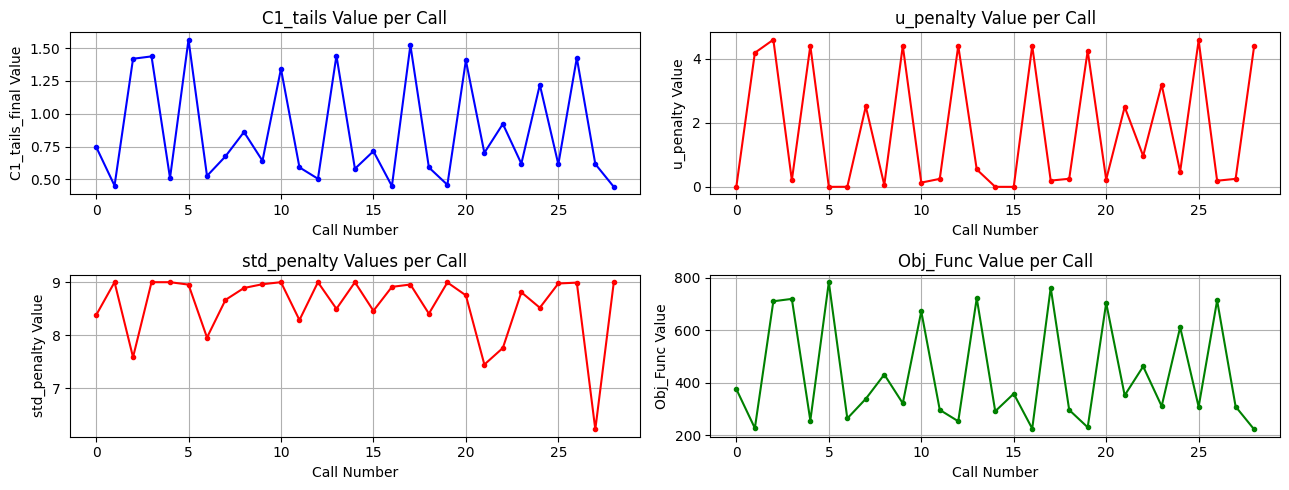

In [ ]:
# Plotting
fig, axs = plt.subplots(2, 2, figsize=(13, 5))

# Plot C1_tails values
axs[0,0].plot(C1_tails_values, marker='.', linestyle='-', color='b')
axs[0,0].set_title('C1_tails Value per Call')
axs[0,0].set_xlabel('Call Number')
axs[0,0].set_ylabel('C1_tails_final Value')
axs[0,0].grid(True)

# Plot u_penalty values
axs[0,1].plot(u_penalty_values, marker='.', linestyle='-', color='r')
axs[0,1].set_title('u_penalty Value per Call')
axs[0,1].set_xlabel('Call Number')
axs[0,1].set_ylabel('u_penalty Value')
axs[0,1].grid(True)

# Plot std_penalty values
axs[1,0].plot(std_penalty_values, marker='.', linestyle='-', color='r')
axs[1,0].set_title('std_penalty Values per Call')
axs[1,0].set_xlabel('Call Number')
axs[1,0].set_ylabel('std_penalty Value')
axs[1,0].grid(True)

#Plot objective function values
axs[1,1].plot(obj_func_values, marker='.', linestyle='-', color='g')
axs[1,1].set_title('Obj_Func Value per Call')
axs[1,1].set_xlabel('Call Number')
axs[1,1].set_ylabel('Obj_Func Value')
axs[1,1].grid(True)

print (u_penalty_values)


plt.tight_layout()  # Adjust layout to not overlap
plt.show()

MAE_hp = 0.022864916383786803
MAE_Qair = 0.0008355546857424977
RMSE_hp = 0.026466101660314694
RMSE_Qair = 0.000985024298766042
C1_tails = 0.862423847127546


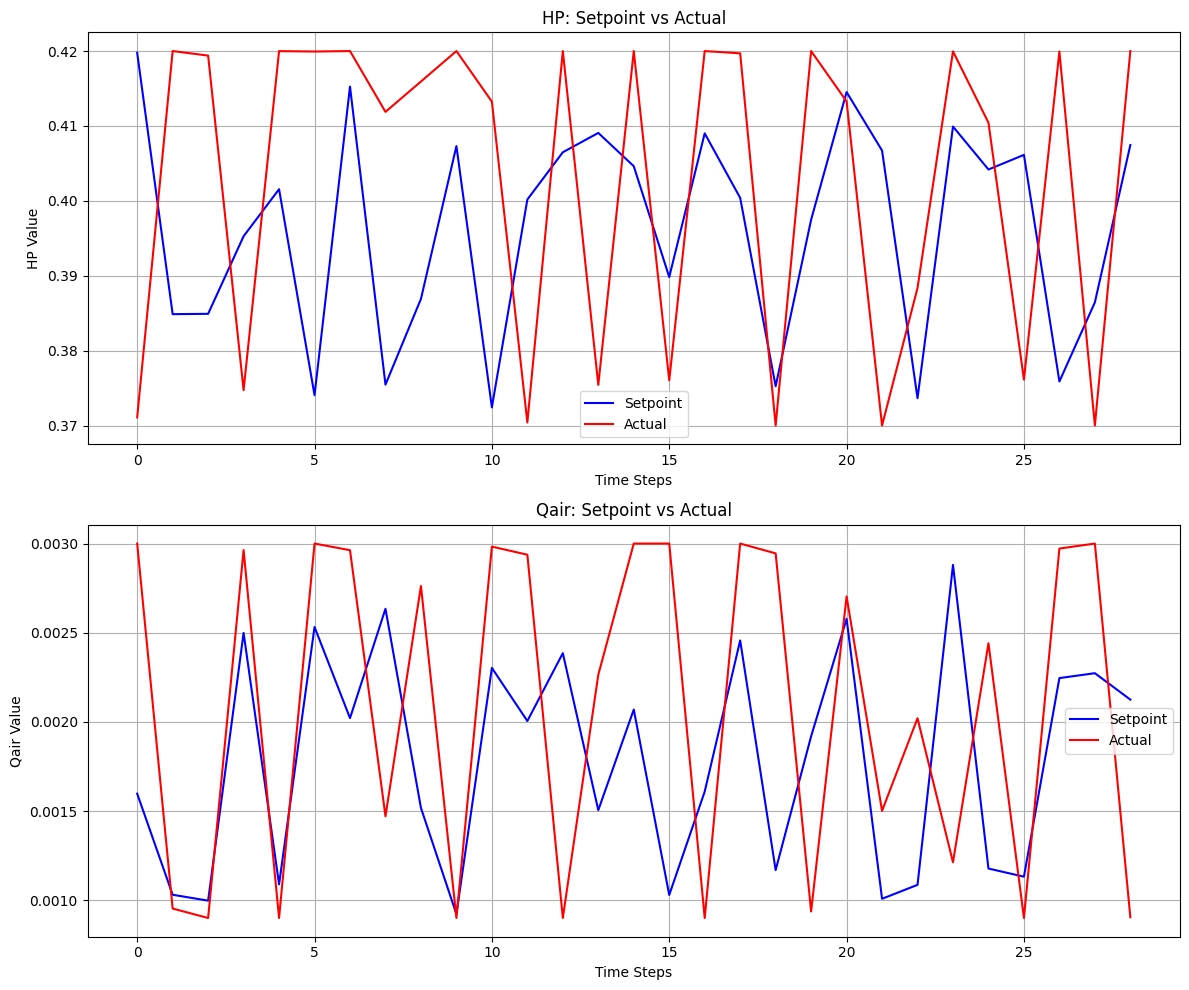

In [ ]:
time_steps = np.arange(mpc_iters)


def calculate_mae(actual, predicted):
    return np.mean(np.abs(actual - predicted))

def calculate_rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted)**2))

setpoints_hp = controls[0, :]
setpoints_Qair = controls[1, :]
actual_hp = data_mpc['U_list'][:, :, 0][0]
actual_Qair = data_mpc['U_list'][:, :, 0][1]

MAE_hp = calculate_mae(actual_hp,setpoints_hp)
MAE_Qair = calculate_mae(actual_Qair, setpoints_Qair)
RMSE_hp = calculate_rmse(actual_hp, setpoints_hp)
RMSE_Qair = calculate_rmse(actual_Qair, setpoints_Qair)

print("MAE_hp =", MAE_hp)
print("MAE_Qair =", MAE_Qair)
print ("RMSE_hp =", RMSE_hp)
print ("RMSE_Qair =", RMSE_Qair)

print("C1_tails =", np.mean(C1_tails_values))

'Plotting Control action VS Setpoint'
setpoints_hp = controls[0, :]
setpoints_Qair = controls[1, :]
actual_hp = data_mpc['U_list'][:, :, 0][0]
actual_Qair = data_mpc['U_list'][:, :, 0][1]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot for hp
ax1.plot(time_steps, setpoints_hp, label='Setpoint', color='blue')
ax1.plot(time_steps, actual_hp, label='Actual', color='red')
ax1.set_title('HP: Setpoint vs Actual')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('HP Value')
ax1.legend()
ax1.grid(True)

# Plot for Qair
ax2.plot(time_steps, setpoints_Qair, label='Setpoint', color='blue')
ax2.plot(time_steps, actual_Qair, label='Actual', color='red')
ax2.set_title('Qair: Setpoint vs Actual')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Qair Value')
ax2.legend()
ax2.grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

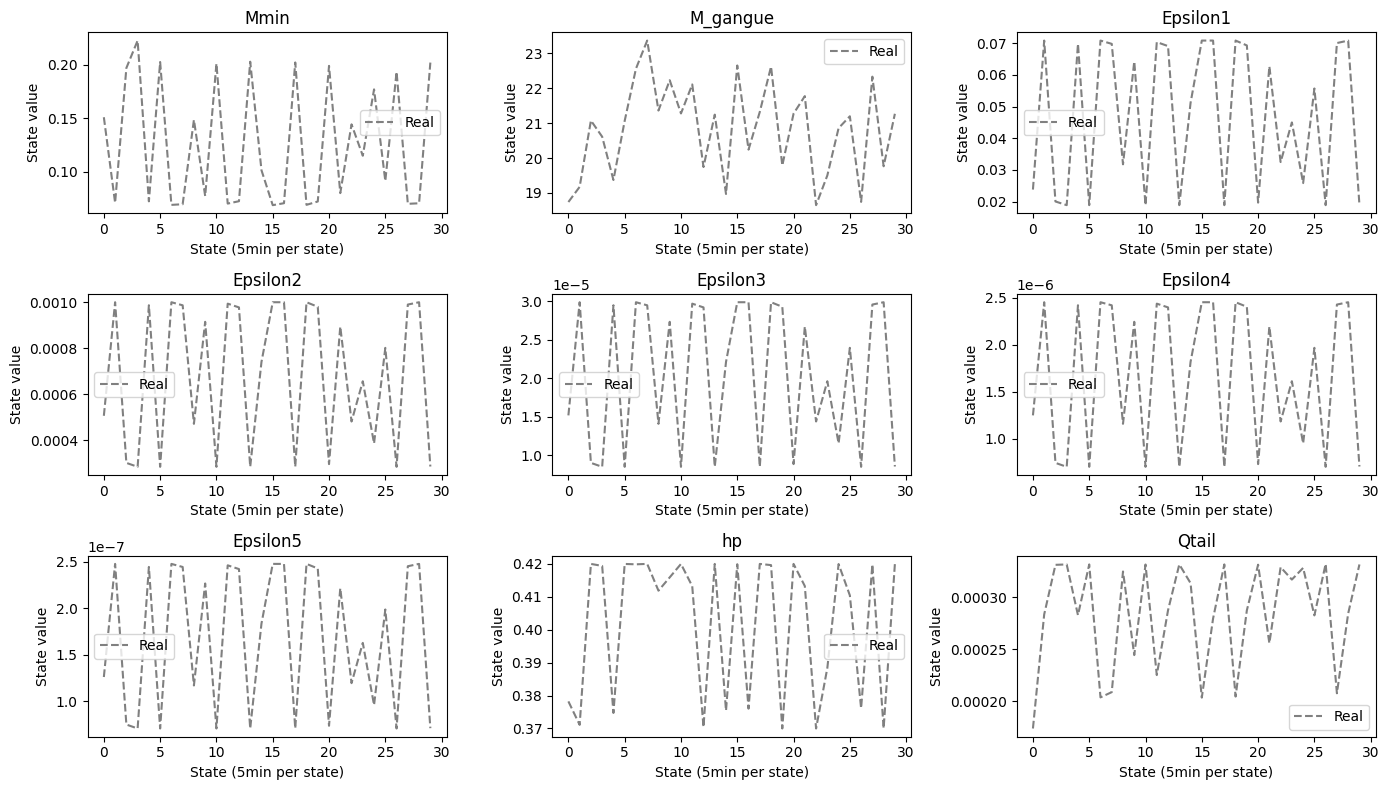

In [ ]:
fig_titles = ['Mmin', 'M_gangue', 'Epsilon1', 'Epsilon2', 'Epsilon3', 'Epsilon4', 'Epsilon5', 'hp', 'Qtail']
fig, axes = plt.subplots(3, 3, figsize=(14,8))
axes = axes.flatten()  # Flatten the axes array for easy iteration

for x_i in range(9):
    ax = axes[x_i]  # Select the appropriate subplot

    # Plot real data (the experimental trajectory from matlab)
    #ax.plot(xt_real[x_i], '--', color='red', label='training data')
    # Plot predicted data for each state variable from MPC runs
    
    # Plot real data (the experimental trajectory from matlab)
    for run_i in range(mpc_runs_n):
        ax.plot(list(data_mpc['X_list'][x_i,:,run_i]), '--', color='grey', label='Real' if run_i == 0 else "")

    ax.set_title(fig_titles[x_i])
    ax.set_ylabel('State value')
    ax.set_xlabel('State (5min per state)')
    ax.legend()
    
plt.tight_layout()  # Adjust subplot parameters to fit into the figure area
plt.show()

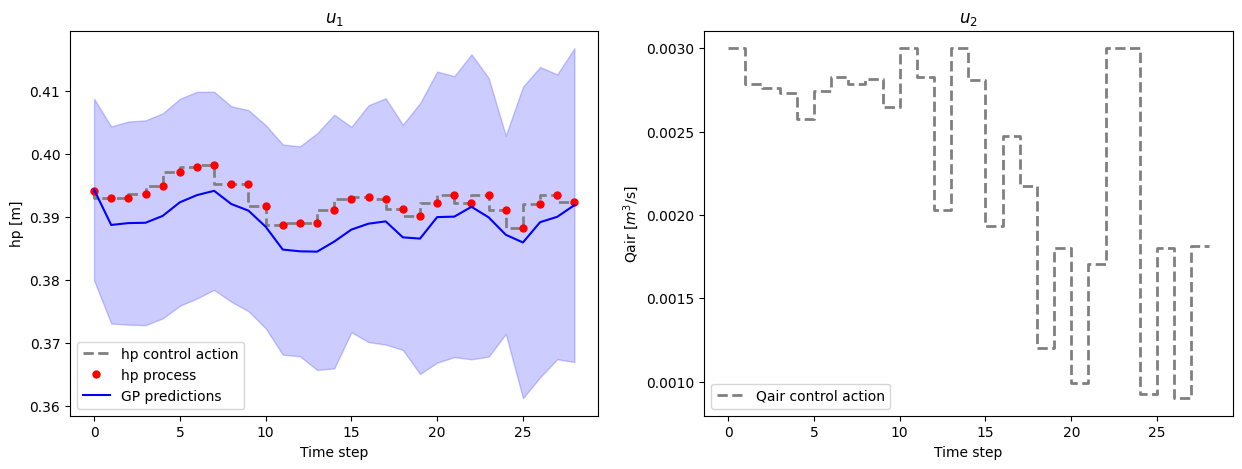

In [275]:

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].step(data_mpc['U_list'][0, :, 0],  '--', color='grey', label='hp control action', linewidth=2)
ax[0].plot(data_mpc['X_list'][7, 1:30, 0], '.', color='red', label='hp process', markersize=10)
ax[0].plot(hp_firststep_values, 'b-', label='GP predictions')
ax[0].fill_between(range(29), hp_firststep_values - 2*np.sqrt(YstdGP_hp_values), hp_firststep_values + 2*np.sqrt(YstdGP_hp_values), color='b', alpha=0.2)
ax[0].set_xlabel('Time step')
ax[0].set_ylabel('hp [m]')
ax[0].legend(loc='best')
ax[0].title.set_text('$u_1$')
ax[1].step(data_mpc['U_list'][1, :, 0],  '--', color='grey', label='Qair control action', linewidth=2) #/0.181*100
ax[1].set_xlabel('Time step')
ax[1].set_ylabel('Qair [$m^3$/s]')
ax[1].legend(loc='best')
ax[1].title.set_text('$u_2$')

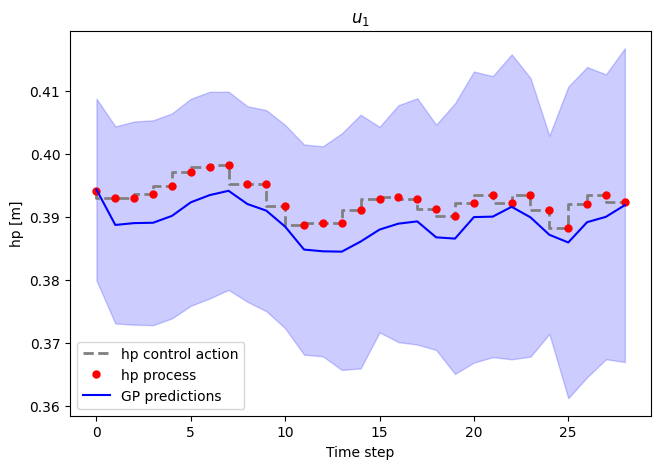

In [276]:
fig, ax = plt.subplots(figsize=(7.5, 5))  # Adjusted figure size for a single plot
ax.step(data_mpc['U_list'][0, :, 0],  '--', color='grey', label='hp control action', linewidth=2)
ax.plot(data_mpc['X_list'][7, 1:30, 0], '.', color='red', label='hp process', markersize=10)
ax.plot(hp_firststep_values, 'b-', label='GP predictions')
ax.fill_between(range(29), hp_firststep_values - 2*np.sqrt(YstdGP_hp_values), hp_firststep_values + 2*np.sqrt(YstdGP_hp_values), color='b', alpha=0.2)
ax.set_xlabel('Time step')
ax.set_ylabel('hp [m]')
ax.legend(loc='best')
ax.title.set_text('$u_1$')

plt.show()  # Display the first plot

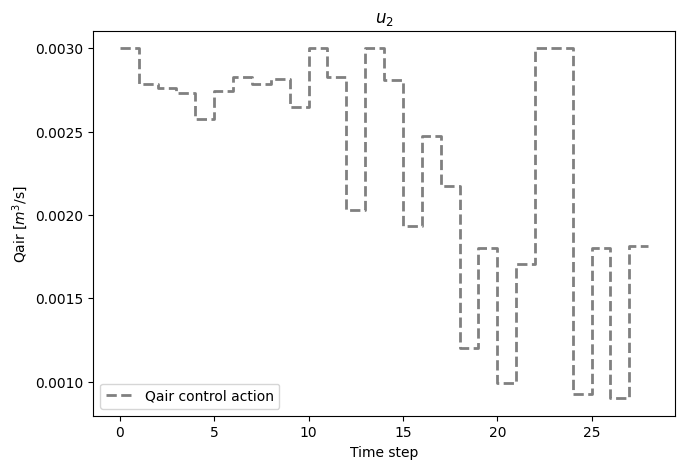

In [277]:
fig, ax = plt.subplots(figsize=(7.5, 5))  # Adjusted figure size for a single plot
ax.step(data_mpc['U_list'][1, :, 0],  '--', color='grey', label='Qair control action', linewidth=2)  # /0.181*100
ax.set_xlabel('Time step')
ax.set_ylabel('Qair [$m^3$/s]')
ax.legend(loc='best')
ax.title.set_text('$u_2$')

plt.show()  # Display the second plot